In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Created wheel for absl-py: filename=absl_py-0.7.1-cp36-none-any.whl size=113722 sha256=3b7ab3141026d9deab3d785655ac0710324b2912e97a2ab5b81fde56ea6897d3
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\ee\98\38\46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=6594 sha256=6960518bb5c0e97ca75ffe4c9e2ded5115edd8a582df116141067f90da79db8e
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for wrapt: filename=wrapt-1.11.2-cp36-none-any.whl size=18733 sha256=5176b75e4d9745e980539f2d90ddcebb542f87a2d289206495c3128aa813c55a
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\d7\de\2e\efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
  Created wheel for termcolor: filename=termcolor-1.1.0-cp36-none-any.whl size=4006 sha256=683d3e5071f9a400da65862dbb17bf5057ec80cce8a7d42c3d364f428b567b9

ERROR: tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Requirement already up-to-date: numpy in c:\users\mayingzh\appdata\roaming\python\python36\site-packages (1.17.0)


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import PReLU, ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skm, math
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mayingzh\AppData\Roaming\Python\Py

# Model Building

## Load data and do data normalization

In [2]:
def moneyness(S,X):
    return S/X

In [3]:
def intrinsic(S, K, C, P):
    return C*(max(S-K, 0)) + P*(max(K-S, 0))

In [4]:
def load_data(file):
    df = pd.read_csv(file)
    df = df.dropna()
    
    # Remove the option data has less than 7 days to maturity.
    df = df[df.maturity > 6]
    
    df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    df = df[df.moneyness >= 0.5]
    df = df[df.moneyness <= 1.5]
    
    # Calculate the intrinsic value of all the options
    df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    
    sample_df = df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    sample_df = sample_df.reset_index(drop=True)
    
    ITM_df = sample_df[sample_df['moneyness'] <= 0.97]
    ATM_df = sample_df[sample_df['moneyness'].between(0.97, 1.03, inclusive = False)]
    OTM_df = sample_df[sample_df['moneyness'] >= 1.03]
    
    return sample_df, ITM_df, ATM_df, OTM_df

In [5]:
sample_df, ITM_df, ATM_df, OTM_df = load_data('Options_R_new.csv')

In [83]:
print('option data shape:', sample_df.shape)
print('In-The_Money option data shape:', ITM_df.shape)
print('An-The_Money option data shape:', ATM_df.shape)
print('Out-The_Money option data shape:', OTM_df.shape)

option data shape: (1700235, 11)
In-The_Money option data shape: (687300, 11)
An-The_Money option data shape: (262052, 11)
Out-The_Money option data shape: (750883, 11)


In [45]:
def get_corr(sample_df):
    corr_matrix = sample_df.corr()
    
    fig = plt.figure(figsize = (10,10))
    sns.heatmap(corr_matrix, vmax = .8, square = True)
    plt.show()
    
    corr = corr_matrix['best_offer'].sort_values(ascending=False)
    print(corr)
    
    return corr

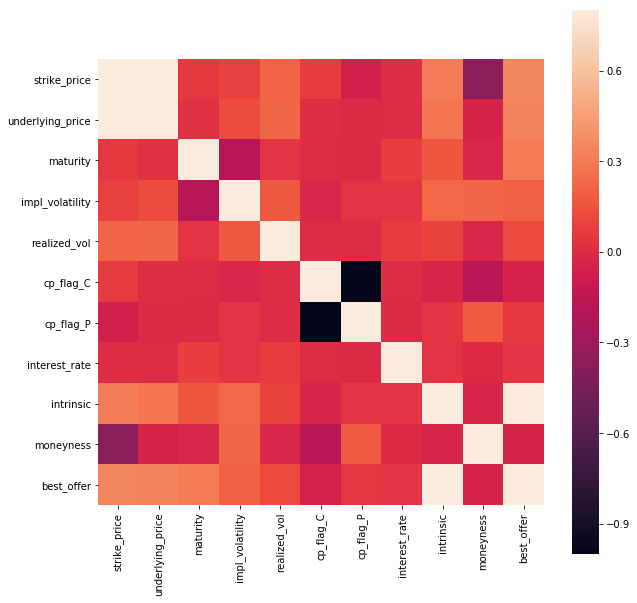

best_offer          1.000000
intrinsic           0.976694
strike_price        0.345604
underlying_price    0.332923
maturity            0.301267
impl_volatility     0.196128
realized_vol        0.118990
cp_flag_P           0.047227
interest_rate       0.038505
moneyness          -0.038097
cp_flag_C          -0.047227
Name: best_offer, dtype: float64


In [46]:
corr = get_corr(sample_df)

In [7]:
def data(s_df):
    
    y = s_df['best_offer'].values
    X = s_df[['intrinsic', 'strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'cp_flag_P', 'interest_rate',]]
    
#     sc_X = StandardScaler()
#     sc_X.fit(X)
#     X_scale = sc_X.fit_transform(X)

#     sc_y = StandardScaler()
    y = y.reshape(-1,1)
#     sc_y.fit(y)
#     y_scale = sc_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test#, sc_X, sc_y

## Build model with in-the-money option data

In [9]:
X_train_ITM, X_test_ITM, y_train_ITM, y_test_ITM = data(ITM_df)

In [12]:
print(X_train_ITM[:10])
print(y_test_ITM[:10])

         intrinsic  strike_price  underlying_price  maturity  impl_volatility  \
1616882       0.00         111.0            102.84        16         0.173117   
1010909       0.00         110.0             81.56       309         0.194168   
677456        9.84         170.0            160.16       148         0.166219   
581542        0.00          50.0             41.41        15         0.388734   
456810        0.00         120.0             92.88       180         0.193109   
1282233      15.99         207.5            191.51        35         0.227236   
717418        0.00         235.0            184.04        10         0.547157   
1346286      20.31         225.0            204.69       165         0.172871   
562445        2.97          45.0             42.03         7         0.296552   
317422        0.00         100.0             96.13       172         0.141775   

         cp_flag_P  interest_rate  
1616882          0         0.0001  
1010909          0         0.0003  


In [13]:
# Because it is a simple regression problem, we should custom metrics function
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def ABS(x):
    return K.abs(x)

def exp(x):
    return K.exp(x)

In [14]:
def create_model(X, y):#neurons_1=1,learn_rate=0.01):
    
    model = Sequential()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto')
    
    model.add(Dense(50, input_shape = (7,), activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(300, activation = 'elu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(1, activation = 'linear'))
    
    #optimizer = Adam()
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
    
    result = model.fit(X,y, epochs = 200, batch_size = 1024, validation_split = 0.1, verbose = 1, callbacks = [es])
    
    # plot training curve for rmse
    plt.figure(figsize = (14, 10))
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('Loss(mse) converge')
    plt.ylabel('Loss(mse)')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    return model, result

W0826 15:46:05.616679 11932 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 15:46:05.639696 11932 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 15:46:05.641697 11932 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 15:46:05.694736 11932 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instea

Train on 494856 samples, validate on 54984 samples
Epoch 1/200
494856/494856 [==============================] - 8s 17us/step - loss: 13.7422 - mean_absolute_error: 1.3015 - val_loss: 0.9389 - val_mean_absolute_error: 0.5338
Epoch 2/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.8408 - mean_absolute_error: 0.5600 - val_loss: 0.4935 - val_mean_absolute_error: 0.4379
Epoch 3/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.5996 - mean_absolute_error: 0.4578 - val_loss: 0.4135 - val_mean_absolute_error: 0.3660
Epoch 4/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.5401 - mean_absolute_error: 0.4329 - val_loss: 0.8200 - val_mean_absolute_error: 0.5024
Epoch 5/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.4918 - mean_absolute_error: 0.4091 - val_loss: 0.4087 - val_mean_absolute_error: 0.3617
Epoch 6/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.4695

494856/494856 [==============================] - 8s 16us/step - loss: 0.2227 - mean_absolute_error: 0.2579 - val_loss: 0.6214 - val_mean_absolute_error: 0.4648
Epoch 49/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.2318 - mean_absolute_error: 0.2640 - val_loss: 0.1941 - val_mean_absolute_error: 0.2378
Epoch 50/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.2207 - mean_absolute_error: 0.2575 - val_loss: 0.1794 - val_mean_absolute_error: 0.2402
Epoch 51/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.2172 - mean_absolute_error: 0.2555 - val_loss: 0.2256 - val_mean_absolute_error: 0.2569
Epoch 52/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.2120 - mean_absolute_error: 0.2515 - val_loss: 0.2007 - val_mean_absolute_error: 0.2335
Epoch 53/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.2304 - mean_absolute_error: 0.2624 - val_loss: 0.1927 - val_mea

494856/494856 [==============================] - 8s 16us/step - loss: 0.1434 - mean_absolute_error: 0.2050 - val_loss: 0.2658 - val_mean_absolute_error: 0.3102
Epoch 96/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1563 - mean_absolute_error: 0.2148 - val_loss: 0.2353 - val_mean_absolute_error: 0.3000
Epoch 97/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1420 - mean_absolute_error: 0.2062 - val_loss: 0.1807 - val_mean_absolute_error: 0.2236
Epoch 98/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1454 - mean_absolute_error: 0.2076 - val_loss: 0.2041 - val_mean_absolute_error: 0.2603
Epoch 99/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1388 - mean_absolute_error: 0.2033 - val_loss: 0.1127 - val_mean_absolute_error: 0.1843
Epoch 100/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1362 - mean_absolute_error: 0.2012 - val_loss: 0.1472 - val_me

494856/494856 [==============================] - 8s 16us/step - loss: 0.1209 - mean_absolute_error: 0.1881 - val_loss: 0.1253 - val_mean_absolute_error: 0.1911
Epoch 143/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1295 - mean_absolute_error: 0.1944 - val_loss: 0.1434 - val_mean_absolute_error: 0.1972
Epoch 144/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1173 - mean_absolute_error: 0.1848 - val_loss: 0.1483 - val_mean_absolute_error: 0.2084
Epoch 145/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1250 - mean_absolute_error: 0.1916 - val_loss: 0.1376 - val_mean_absolute_error: 0.2039
Epoch 146/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1202 - mean_absolute_error: 0.1884 - val_loss: 0.2670 - val_mean_absolute_error: 0.2794
Epoch 147/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1223 - mean_absolute_error: 0.1891 - val_loss: 0.1046 - va

494856/494856 [==============================] - 8s 16us/step - loss: 0.1198 - mean_absolute_error: 0.1867 - val_loss: 0.1034 - val_mean_absolute_error: 0.1740
Epoch 190/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.1121 - mean_absolute_error: 0.1812 - val_loss: 0.1015 - val_mean_absolute_error: 0.1748


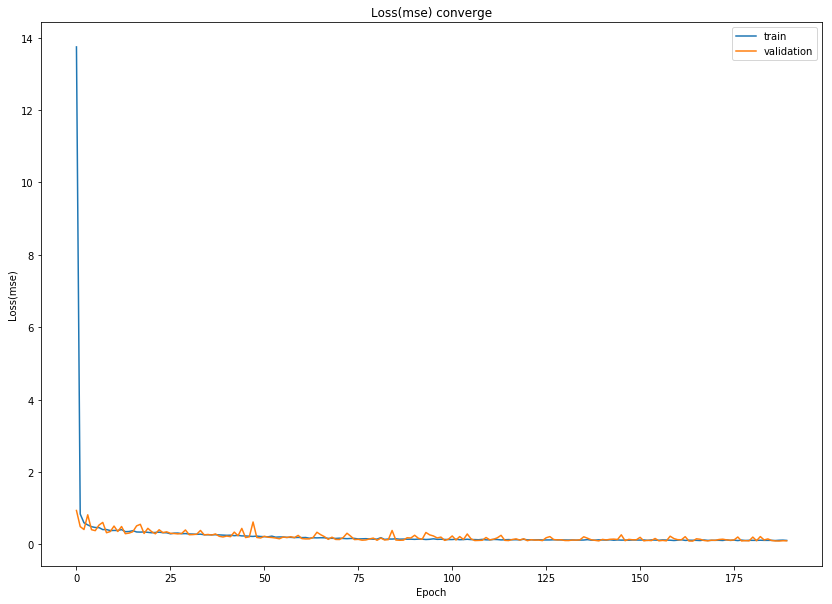

Wall time: 25min 26s


In [15]:
%time model_ITM, result_ITM = create_model(X_train_ITM, y_train_ITM)

In [112]:
def pred(model, X, y):
    
    pred = model.predict(X)

#     pred = sc_y.inverse_transform(pred)
#     y = sc_y.inverse_transform(y)

    pred = pred.flatten()
    y = y.flatten()

    d = {'predicted': pred, 'actual': y}
    pred_df = pd.DataFrame(data = d)
    display(pred_df.head(10))

    pred_sample = pred_df.sample(n = 150)

    pred_sample.sort_index(axis = 0, inplace = True)
    
    plt.figure(1, figsize = (15,10))
    plt.plot(pred_sample.index, pred_sample['predicted'], linestyle = '-', label = 'predicted', color = 'r')
    plt.plot(pred_sample.index, pred_sample['actual'], linestyle = '-', label = 'actual', alpha = 0.5)
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Predicted vs Actual Values', fontsize = 30)
    plt.show()
    
    l,binEdges=np.histogram(np.abs(pred_sample['predicted']-pred_sample['actual']),bins= [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
#     print(binEdges)
#     bincenters = binEdges[1:]+binEdges[:-1]
#     print(bincenters)
    plt.figure(2, figsize = (15,10))
    plt.plot(binEdges[1:],l,'-')
    plt.xlabel('Error', fontsize = 20)
    plt.ylabel('Frequency', fontsize = 20)
    plt.title('Absolute Error Frequency Between Predicted Value and Actual Value', fontsize = 30)
    plt.show()
    
        
    #Histogram of diff for all data
    plt.figure(3,figsize = (15,10))
    n, bins, patches = plt.hist(np.abs(pred_df['predicted']-pred_df['actual']), 10, range = (0,5),density=True, color='blue', alpha=0.75,rwidth = 0.9)
    plt.xlabel('Value', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
#     plt.xticks(fontsize=40)
#     plt.yticks(fontsize=40)
    plt.title('Distribution of Difference between Prediction & Actual for sample data', fontsize=30) 
    
    #print('The percentage of abs error less than 1:', CountPairsPrecent(pred_sample['predicted'], pred_sample['actual'], len(pred_sample)))
    #plt.plot(pred_sample.index, np.abs(pred_sample['predicted']-pred_sample['actual']), linestyle = '-', label = 'predicted', color = 'r')
    print('\n')
    print("Mean absolute error (MAE): %f" % skm.mean_absolute_error(y,pred))
    print("Mean squared error (MSE):  %f" % skm.mean_squared_error(y,pred))
    print("R square (R^2):            %f" % skm.r2_score(y,pred))

,predicted,actual
0,0.273492,0.27
1,0.360759,0.47
2,31.288301,30.20
3,8.208784,7.75
4,0.055357,0.05
5,0.442619,0.50
6,0.098593,0.10
7,7.501704,7.05
8,0.178057,0.13
9,0.107303,0.11


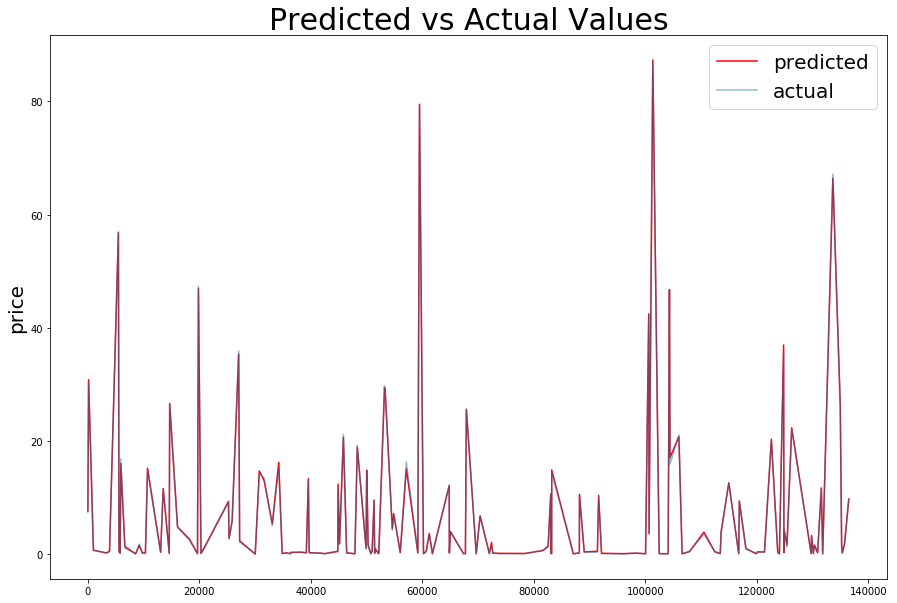

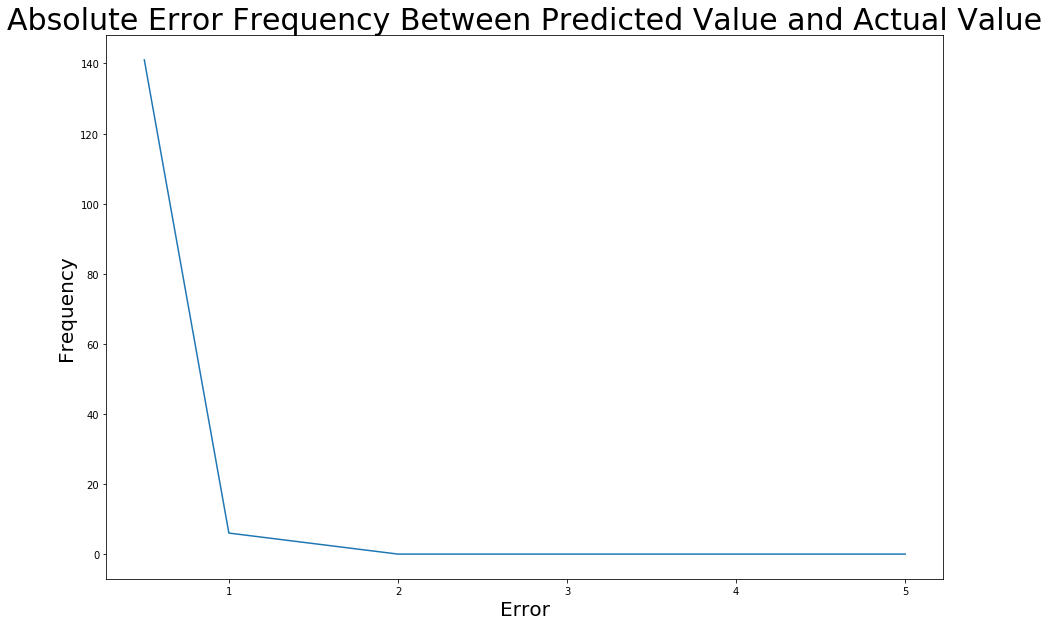



Mean absolute error (MAE): 0.175943
Mean squared error (MSE):  0.102059
R square (R^2):            0.999537


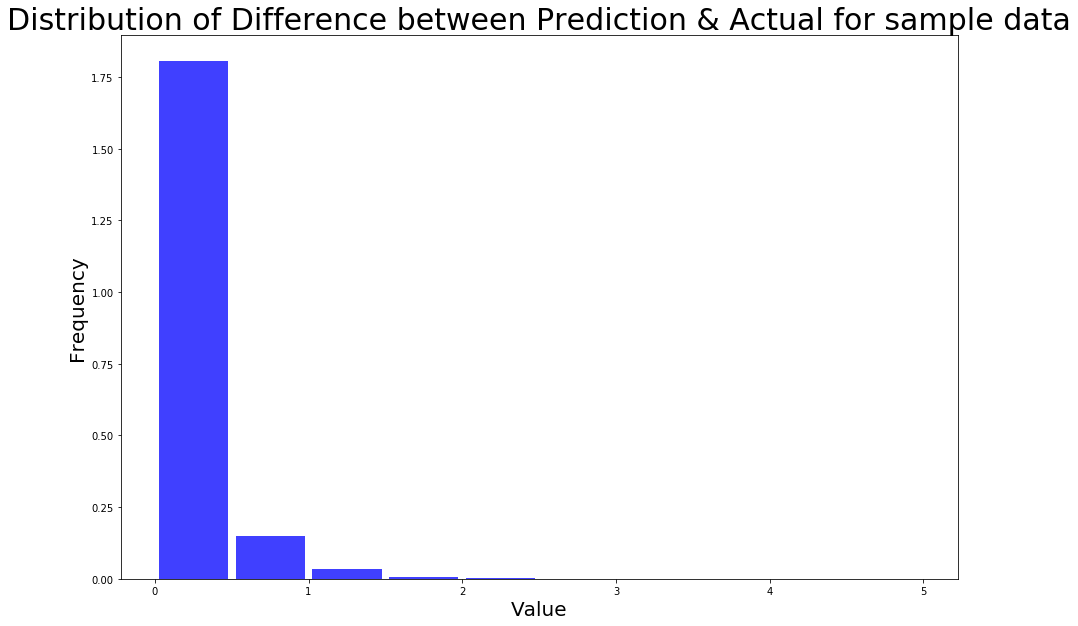

In [113]:
pred_ITM = pred(model_ITM, X_test_ITM, y_test_ITM)

In [25]:
model_ITM.save('model4_2_ITM_ori.h5')

## Build model with at-the-money option data

In [26]:
X_train_ATM, X_test_ATM, y_train_ATM, y_test_ATM = data(ATM_df)

Train on 188676 samples, validate on 20965 samples
Epoch 1/200
188676/188676 [==============================] - 4s 19us/step - loss: 6.0954 - mean_absolute_error: 1.2801 - val_loss: 1.0935 - val_mean_absolute_error: 0.7038
Epoch 2/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.8805 - mean_absolute_error: 0.5986 - val_loss: 0.7525 - val_mean_absolute_error: 0.5464
Epoch 3/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.7621 - mean_absolute_error: 0.5595 - val_loss: 0.8603 - val_mean_absolute_error: 0.5677
Epoch 4/200
188676/188676 [==============================] - 3s 18us/step - loss: 0.7188 - mean_absolute_error: 0.5427 - val_loss: 0.7717 - val_mean_absolute_error: 0.5613
Epoch 5/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.6716 - mean_absolute_error: 0.5269 - val_loss: 0.6798 - val_mean_absolute_error: 0.5640
Epoch 6/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.6438 

188676/188676 [==============================] - 3s 16us/step - loss: 0.2239 - mean_absolute_error: 0.2622 - val_loss: 0.2539 - val_mean_absolute_error: 0.2601
Epoch 49/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.2161 - mean_absolute_error: 0.2574 - val_loss: 0.1604 - val_mean_absolute_error: 0.2043
Epoch 50/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1986 - mean_absolute_error: 0.2417 - val_loss: 0.1557 - val_mean_absolute_error: 0.1966
Epoch 51/200
188676/188676 [==============================] - 4s 22us/step - loss: 0.2216 - mean_absolute_error: 0.2598 - val_loss: 0.1935 - val_mean_absolute_error: 0.2425
Epoch 52/200
188676/188676 [==============================] - 3s 18us/step - loss: 0.2024 - mean_absolute_error: 0.2490 - val_loss: 0.1523 - val_mean_absolute_error: 0.1898
Epoch 53/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.1954 - mean_absolute_error: 0.2401 - val_loss: 0.1633 - val_mea

188676/188676 [==============================] - 3s 16us/step - loss: 0.1268 - mean_absolute_error: 0.1966 - val_loss: 0.0894 - val_mean_absolute_error: 0.1629
Epoch 96/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1202 - mean_absolute_error: 0.1931 - val_loss: 0.2769 - val_mean_absolute_error: 0.2467
Epoch 97/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1063 - mean_absolute_error: 0.1838 - val_loss: 0.0620 - val_mean_absolute_error: 0.1567
Epoch 98/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1452 - mean_absolute_error: 0.2125 - val_loss: 0.1288 - val_mean_absolute_error: 0.1908
Epoch 99/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1108 - mean_absolute_error: 0.1881 - val_loss: 0.1291 - val_mean_absolute_error: 0.1806
Epoch 100/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1136 - mean_absolute_error: 0.1870 - val_loss: 0.1156 - val_me

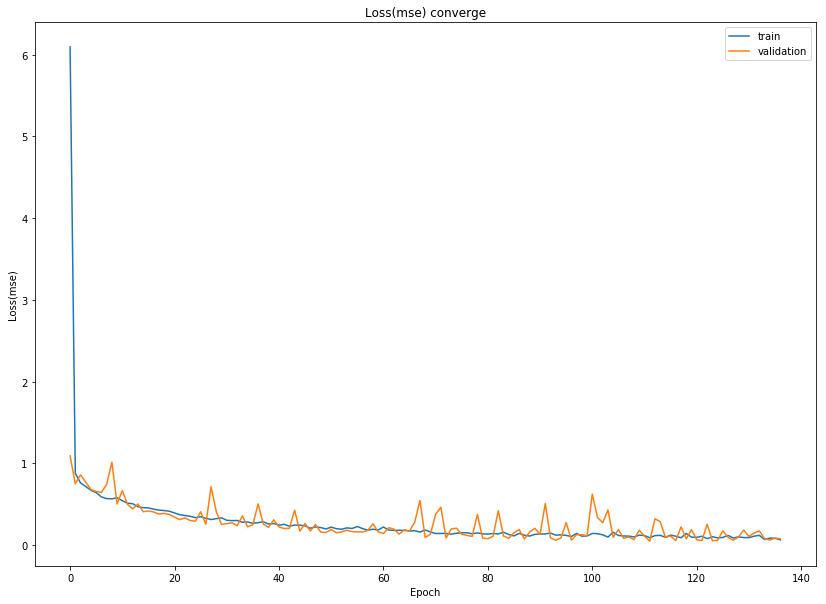

Wall time: 7min 4s


In [27]:
%time model_ATM, result_ATM = create_model(X_train_ATM, y_train_ATM)

,predicted,actual
0,0.844710,0.88
1,1.868323,1.93
2,7.030748,7.70
3,3.332389,3.45
4,0.554959,0.62
5,0.539635,0.59
6,1.305239,1.38
7,0.486971,0.53
8,2.387469,2.49
9,0.350336,0.44


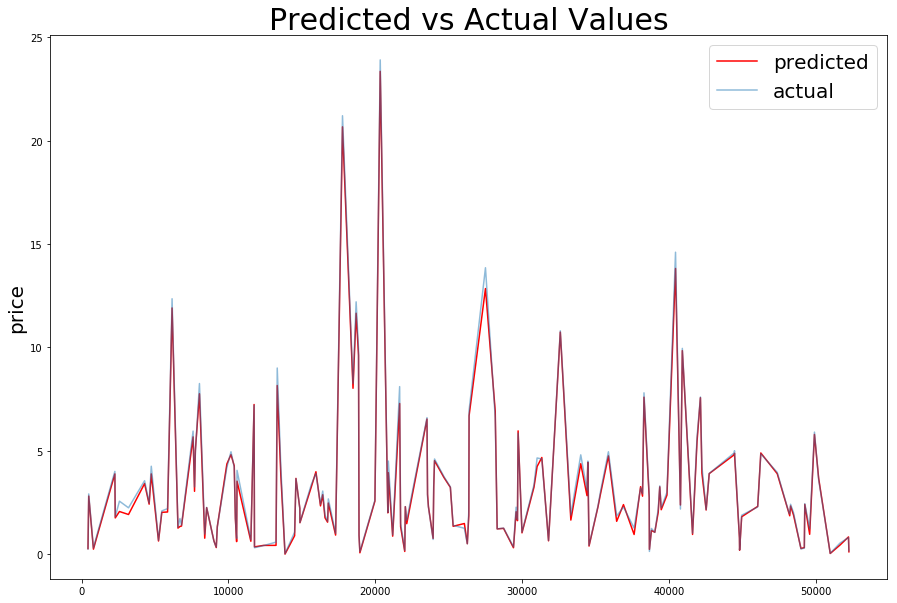

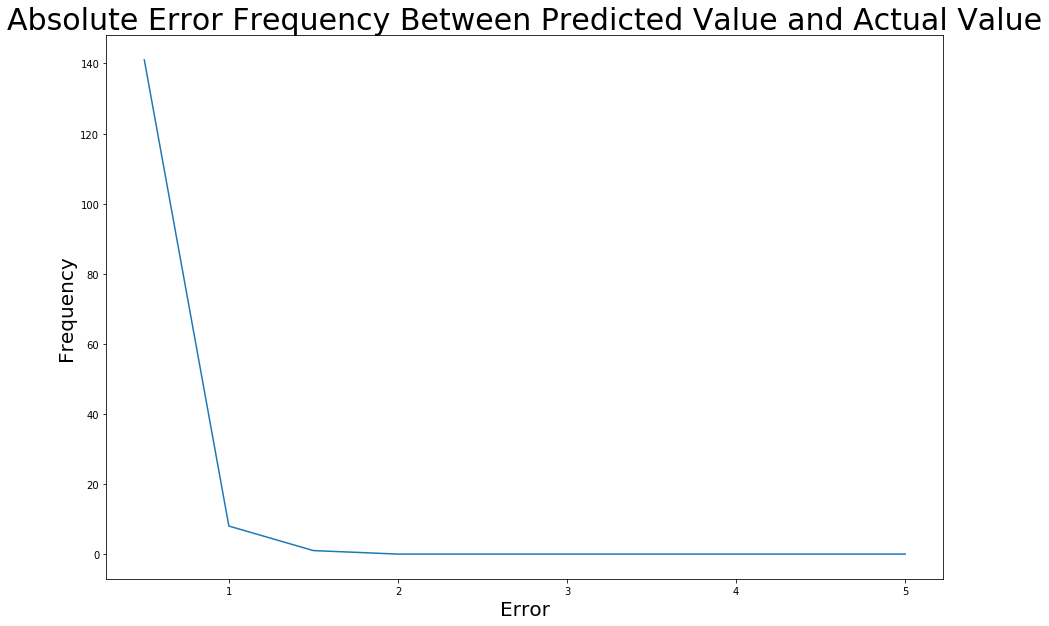



Mean absolute error (MAE): 0.158839
Mean squared error (MSE):  0.076498
R square (R^2):            0.994295


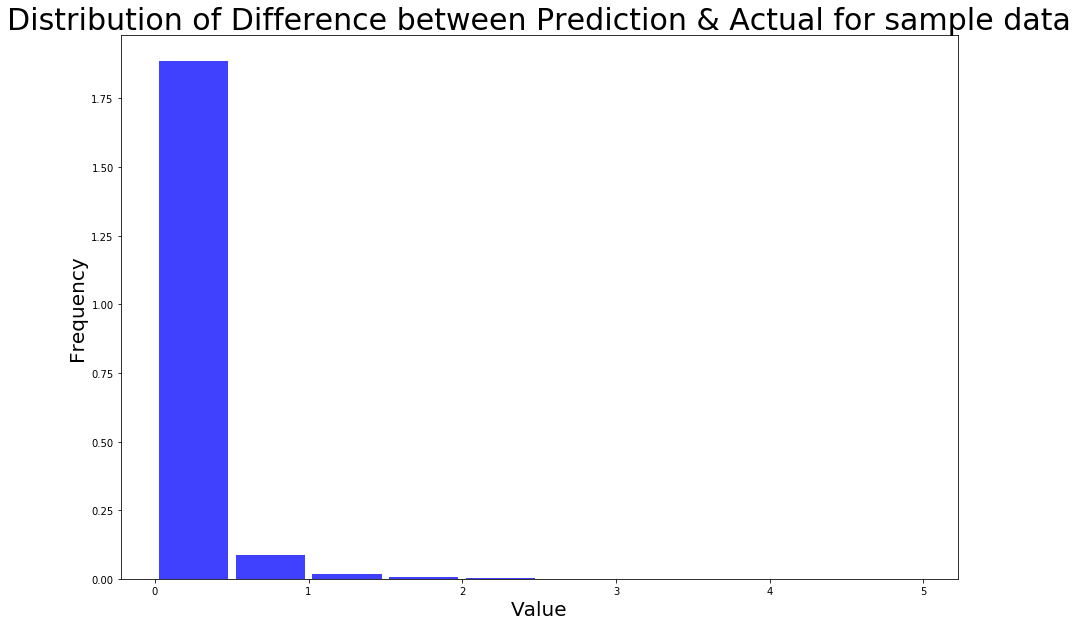

In [114]:
pred_ATM = pred(model_ATM, X_test_ATM, y_test_ATM)

In [57]:
model_ATM.save('model4_2_ATM_ori.h5')

## Build model with out-the-money option data

In [58]:
X_train_OTM, X_test_OTM, y_train_OTM, y_test_OTM = data(OTM_df)

Train on 540635 samples, validate on 60071 samples
Epoch 1/200
540635/540635 [==============================] - 10s 18us/step - loss: 10.2779 - mean_absolute_error: 1.1972 - val_loss: 0.8151 - val_mean_absolute_error: 0.6052
Epoch 2/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.7971 - mean_absolute_error: 0.5490 - val_loss: 0.6758 - val_mean_absolute_error: 0.5343
Epoch 3/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.6563 - mean_absolute_error: 0.4878 - val_loss: 0.4673 - val_mean_absolute_error: 0.3899
Epoch 4/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.6243 - mean_absolute_error: 0.4712 - val_loss: 0.4603 - val_mean_absolute_error: 0.3770
Epoch 5/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.4987 - mean_absolute_error: 0.4154 - val_loss: 0.4300 - val_mean_absolute_error: 0.4166
Epoch 6/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.484

540635/540635 [==============================] - 9s 16us/step - loss: 0.1822 - mean_absolute_error: 0.2333 - val_loss: 0.1117 - val_mean_absolute_error: 0.1861
Epoch 49/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.1696 - mean_absolute_error: 0.2259 - val_loss: 0.1337 - val_mean_absolute_error: 0.1990
Epoch 50/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.1579 - mean_absolute_error: 0.2167 - val_loss: 0.1366 - val_mean_absolute_error: 0.2115
Epoch 51/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.1549 - mean_absolute_error: 0.2155 - val_loss: 0.1163 - val_mean_absolute_error: 0.1864
Epoch 52/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.1518 - mean_absolute_error: 0.2133 - val_loss: 0.1174 - val_mean_absolute_error: 0.1860
Epoch 53/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.1641 - mean_absolute_error: 0.2203 - val_loss: 0.1902 - val_mea

540635/540635 [==============================] - 10s 18us/step - loss: 0.1082 - mean_absolute_error: 0.1810 - val_loss: 0.0720 - val_mean_absolute_error: 0.1451
Epoch 96/200
540635/540635 [==============================] - 10s 18us/step - loss: 0.1102 - mean_absolute_error: 0.1829 - val_loss: 0.0817 - val_mean_absolute_error: 0.1611
Epoch 97/200
540635/540635 [==============================] - 9s 18us/step - loss: 0.1120 - mean_absolute_error: 0.1835 - val_loss: 0.0756 - val_mean_absolute_error: 0.1542
Epoch 98/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.0989 - mean_absolute_error: 0.1740 - val_loss: 0.0907 - val_mean_absolute_error: 0.1638
Epoch 99/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.1029 - mean_absolute_error: 0.1763 - val_loss: 0.0771 - val_mean_absolute_error: 0.1506
Epoch 100/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.1058 - mean_absolute_error: 0.1790 - val_loss: 0.0766 - val_

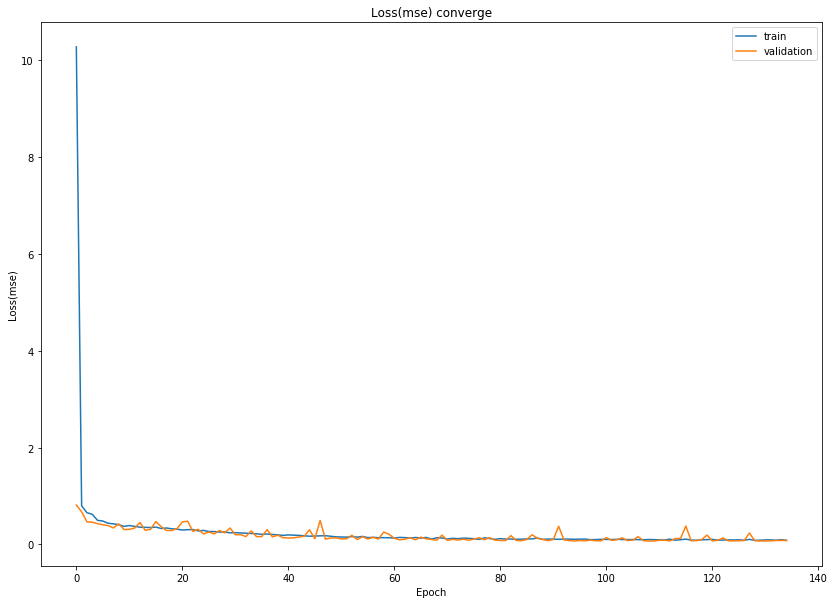

Wall time: 20min 55s


In [59]:
%time model_OTM, result_OTM = create_model(X_train_OTM, y_train_OTM)

,predicted,actual
0,0.270436,0.27
1,0.100984,0.12
2,0.147467,0.21
3,0.393130,0.50
4,0.075511,0.04
5,37.201881,37.45
6,0.300857,0.36
7,0.750905,0.84
8,0.491578,0.61
9,0.072710,0.07


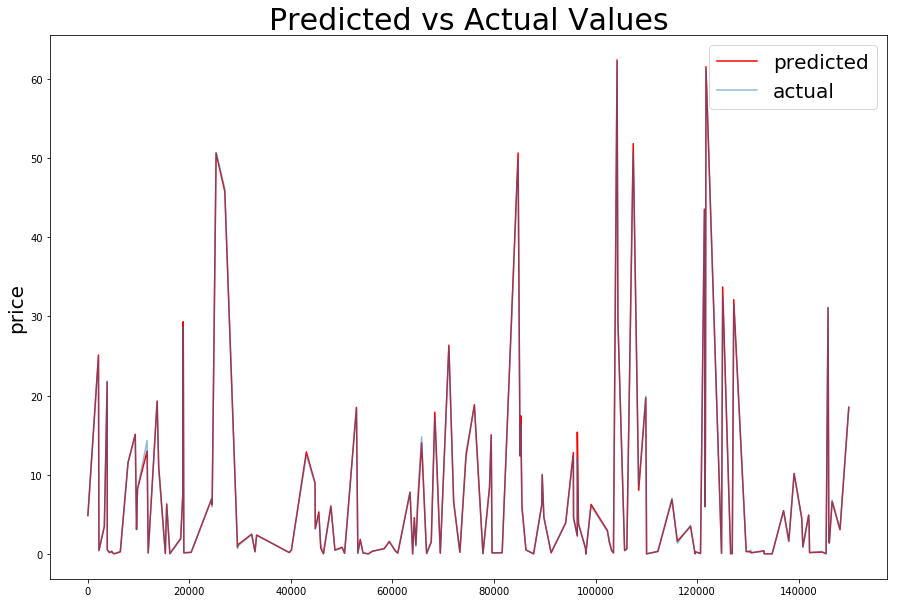

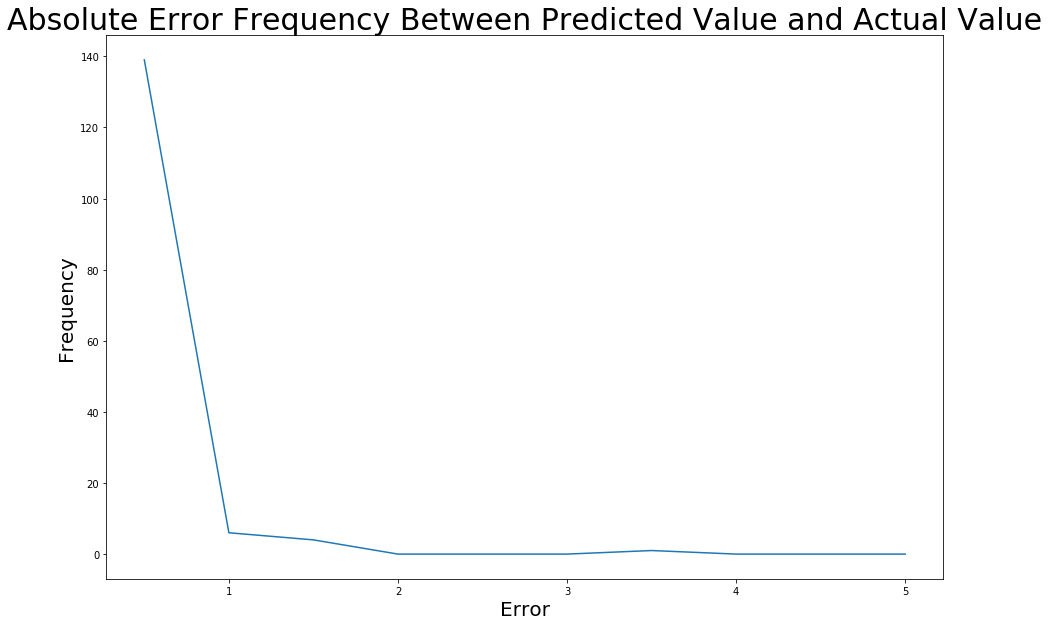



Mean absolute error (MAE): 0.154734
Mean squared error (MSE):  0.082027
R square (R^2):            0.999282


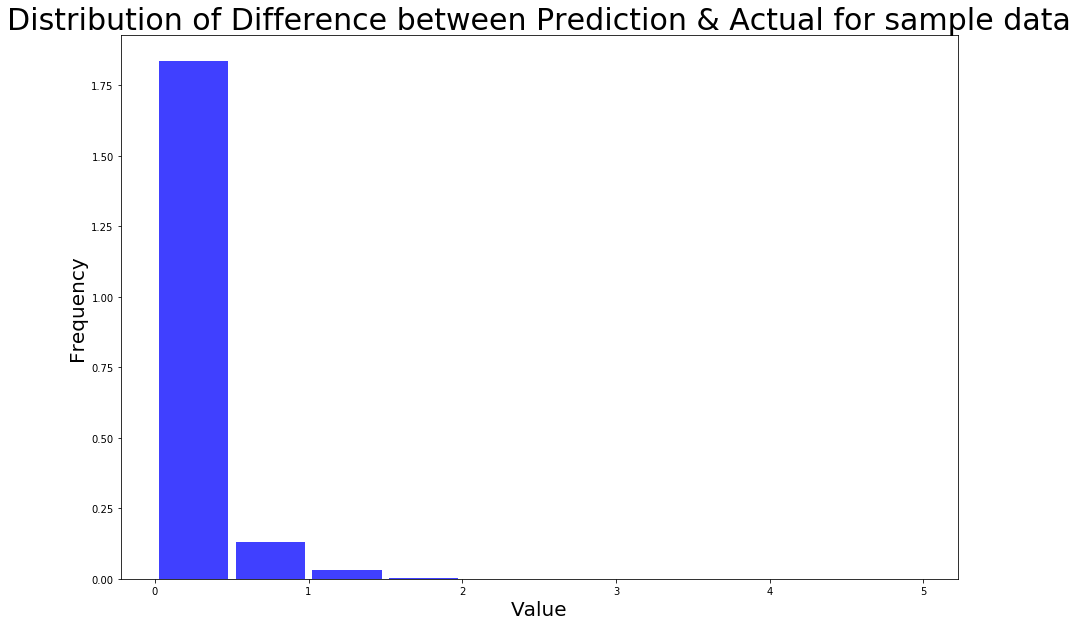

In [115]:
pred_OTM = pred(model_OTM, X_test_OTM, y_test_OTM)

In [61]:
model_OTM.save('model4_2_OTM_ori.h5')

## Build model with whole data

In [86]:
X_train, X_test, y_train, y_test = data(sample_df.sample(frac = 0.7))

In [87]:
print(X_train[:10])
print(y_train[:10])

         intrinsic  strike_price  underlying_price  maturity  impl_volatility  \
34139         0.00          95.0            126.25       438         0.347082   
1046743       0.00          72.5             78.81       592         0.214322   
882199        0.00          63.0             76.48        14         0.453920   
1378006      34.51         145.0            179.51       464         0.301632   
1033293       2.66          80.5             77.84        31         0.126935   
1285363      59.79         130.0            189.79       231         0.352158   
1155150       0.00          49.0             40.02       155         0.202670   
748155        0.00         232.5            188.41        35         0.261289   
1132835       0.00          49.0             42.56       121         0.190029   
1568580      10.13         105.0             94.87        36         0.368435   

         cp_flag_P  interest_rate  
34139            1         0.0010  
1046743          1         0.0002  


Train on 856917 samples, validate on 95214 samples
Epoch 1/200
856917/856917 [==============================] - 15s 17us/step - loss: 5.9502 - mean_absolute_error: 0.9221 - val_loss: 0.5802 - val_mean_absolute_error: 0.4663
Epoch 2/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.6350 - mean_absolute_error: 0.4926 - val_loss: 0.5211 - val_mean_absolute_error: 0.4429
Epoch 3/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.5209 - mean_absolute_error: 0.4378 - val_loss: 0.4063 - val_mean_absolute_error: 0.3754
Epoch 4/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.4400 - mean_absolute_error: 0.3994 - val_loss: 0.3773 - val_mean_absolute_error: 0.3606
Epoch 5/200
856917/856917 [==============================] - 14s 16us/step - loss: 0.4219 - mean_absolute_error: 0.3892 - val_loss: 0.5565 - val_mean_absolute_error: 0.4709
Epoch 6/200
856917/856917 [==============================] - 14s 16us/step - loss: 0

Epoch 48/200
856917/856917 [==============================] - 14s 16us/step - loss: 0.1290 - mean_absolute_error: 0.1986 - val_loss: 0.1008 - val_mean_absolute_error: 0.1703
Epoch 49/200
856917/856917 [==============================] - 14s 16us/step - loss: 0.1173 - mean_absolute_error: 0.1887 - val_loss: 0.1027 - val_mean_absolute_error: 0.1769
Epoch 50/200
856917/856917 [==============================] - 14s 16us/step - loss: 0.1209 - mean_absolute_error: 0.1919 - val_loss: 0.0873 - val_mean_absolute_error: 0.1628
Epoch 51/200
856917/856917 [==============================] - 14s 16us/step - loss: 0.1322 - mean_absolute_error: 0.2008 - val_loss: 0.0859 - val_mean_absolute_error: 0.1633
Epoch 52/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.1255 - mean_absolute_error: 0.1947 - val_loss: 0.1155 - val_mean_absolute_error: 0.2014
Epoch 53/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.1198 - mean_absolute_error: 0.1909 - val_los

856917/856917 [==============================] - 14s 16us/step - loss: 0.0974 - mean_absolute_error: 0.1711 - val_loss: 0.1017 - val_mean_absolute_error: 0.1784
Epoch 96/200
856917/856917 [==============================] - 14s 16us/step - loss: 0.0998 - mean_absolute_error: 0.1720 - val_loss: 0.0808 - val_mean_absolute_error: 0.1631
Epoch 97/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.0963 - mean_absolute_error: 0.1703 - val_loss: 0.0990 - val_mean_absolute_error: 0.1779
Epoch 98/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.0957 - mean_absolute_error: 0.1703 - val_loss: 0.0839 - val_mean_absolute_error: 0.1631
Epoch 99/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.0960 - mean_absolute_error: 0.1703 - val_loss: 0.1090 - val_mean_absolute_error: 0.1728
Epoch 100/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.0956 - mean_absolute_error: 0.1695 - val_loss: 0.1103 - 

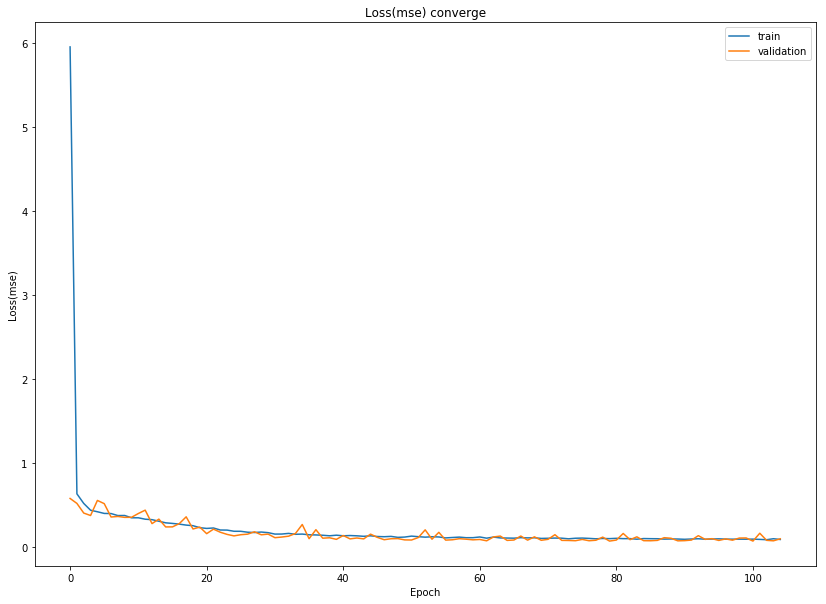

Wall time: 25min 10s


In [88]:
%time model, result = create_model(X_train, y_train)

,predicted,actual
0,4.285762,5.10
1,0.173995,0.20
2,25.432657,24.90
3,5.813066,5.95
4,0.172120,0.14
5,21.318890,21.05
6,43.543083,42.90
7,0.919411,0.93
8,0.071861,0.10
9,0.030168,0.02


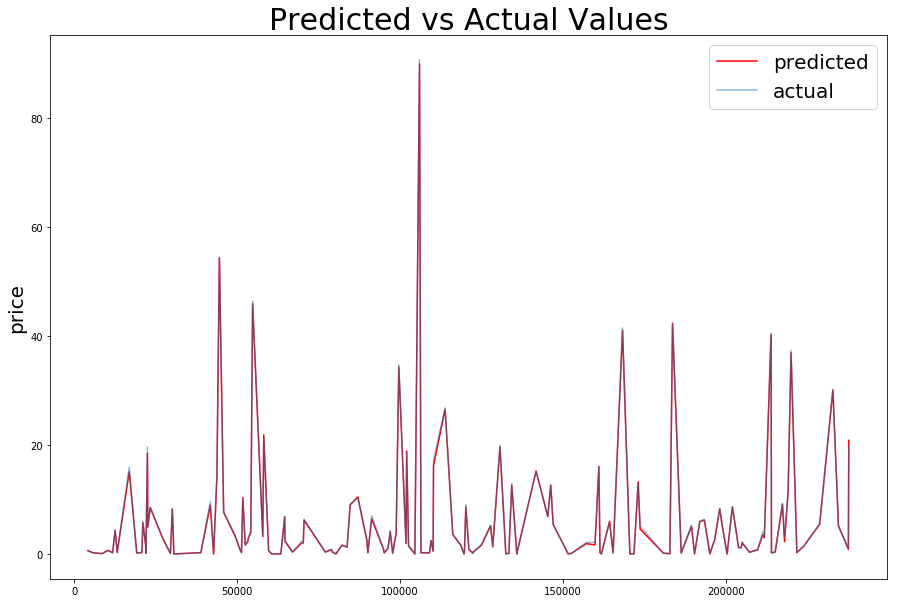

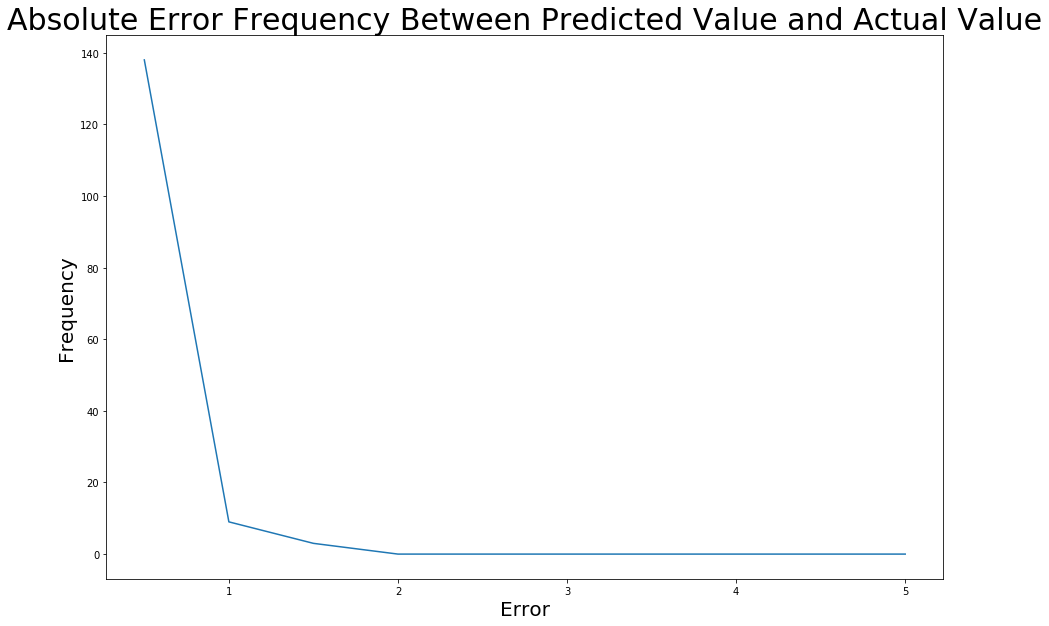



Mean absolute error (MAE): 0.173191
Mean squared error (MSE):  0.102538
R square (R^2):            0.999296


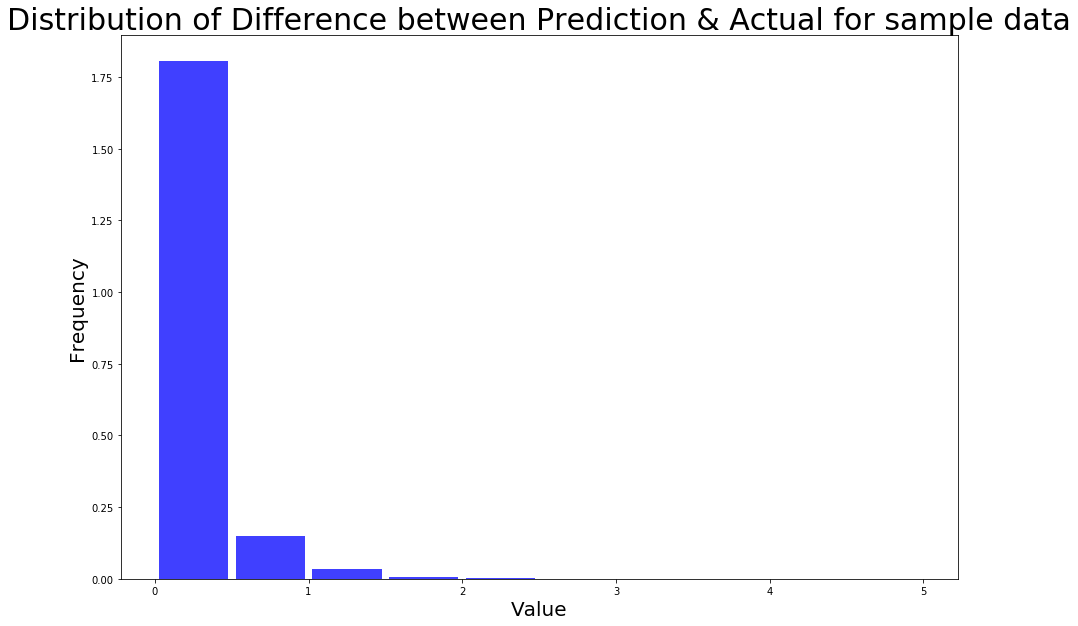

In [116]:
pred_whole = pred(model, X_test, y_test)

# Prediction

We use the three models we built above to do option price prediction. In the above, the train and test dataset were generated from the same dataset, even though they were splited randomly, the data structures were very similar. In this section, we want to apply the models to out of sample data which is in different time range from the data used to train the model to check our models' robustness. 

In [62]:
def load_prediction_data():
    df = pd.read_csv('Options_R_test.csv')
    df = df.dropna()
    
    # Calculate the intrinsic value of all the options
    df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    
    df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    
    df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    #sample_df = sample_df.reset_index(drop=True)
    ITM_df = df[df['moneyness'] <= 0.97]
    ATM_df = df[df['moneyness'].between(0.97, 1.03, inclusive = False)]
    OTM_df = df[df['moneyness'] >= 1.03]
    
    return df, ITM_df, ATM_df, OTM_df

In [63]:
p_df, p_df_ITM, p_df_ATM, p_df_OTM = load_prediction_data()

In [97]:
def model_pred(df, model, vol):
    
    y = df['best_offer'].values
    X = df[[ 'intrinsic', 'strike_price', 'underlying_price', 'maturity', vol, 'cp_flag_P', 'interest_rate',]]
    
#     sc_X = StandardScaler()
#     sc_X.fit(X)
#     X_scale = sc_X.transform(X)

#     sc_y = StandardScaler()
#     y = y.reshape(-1,1)
#     sc_y.fit(y)
#     y_scale = sc_y.fit_transform(y)
    
    pred = model.predict(X)
    
    pred = pred.flatten()
#     y_scale = y_scale.flatten()
    y = y.flatten()
#     y_pred = sc_y.inverse_transform(pred)
    
    d = {'predict': pred, 'actual':y}
    datanew = pd.DataFrame(data = d)
    display(datanew.head(10))
      
    sample_data = datanew.sample(n=150)
    
    sample_data.sort_index(axis = 0, inplace = True)
    
    plt.figure(1, figsize = (15,10))
    plt.plot(sample_data.index, sample_data['predict'], linestyle = '-', label = 'predicted', color = 'r')
    plt.plot(sample_data.index, sample_data['actual'], linestyle = '-', label = 'actual', alpha = 0.5)
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Predicted vs Actual Values', fontsize = 30)
    plt.show()
    
    l,binEdges=np.histogram(np.abs(sample_data['predict']-sample_data['actual']),bins= [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
    plt.figure(2, figsize = (15,10))
    plt.plot(binEdges[1:],l,'-')
    plt.xlabel('Error', fontsize = 20)
    plt.ylabel('Frequency', fontsize = 20)
    plt.title('Absolute Error Frequency Between Predicted Value and Actual Value', fontsize = 30)
    plt.show()
     
    #Histogram of diff for all data
    plt.figure(3,figsize = (15,10))
    n, bins, patches = plt.hist(np.abs(datanew['predict']-datanew['actual']), 10, range = (0,5),density=True, color='blue', alpha=0.75,rwidth = 0.9)
    plt.xlabel('Value', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
#     plt.xticks(fontsize=40)
#     plt.yticks(fontsize=40)
    plt.title('Distribution of Difference between Prediction & Actual for sample data', fontsize=30) 
    

    print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y, pred))
    print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y, pred))
    #print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y, y_pred)))
    print("R square (R^2):                 %f" % skm.r2_score(y, pred))

## Predict in-the-money option data

,predict,actual
0,1.188669,0.13
1,1.766448,0.13
2,0.199437,0.06
3,0.169284,0.04
4,0.149611,0.03
5,0.122559,0.03
6,0.130382,0.03
7,0.098063,0.02
8,0.203751,0.06
9,0.195515,0.05


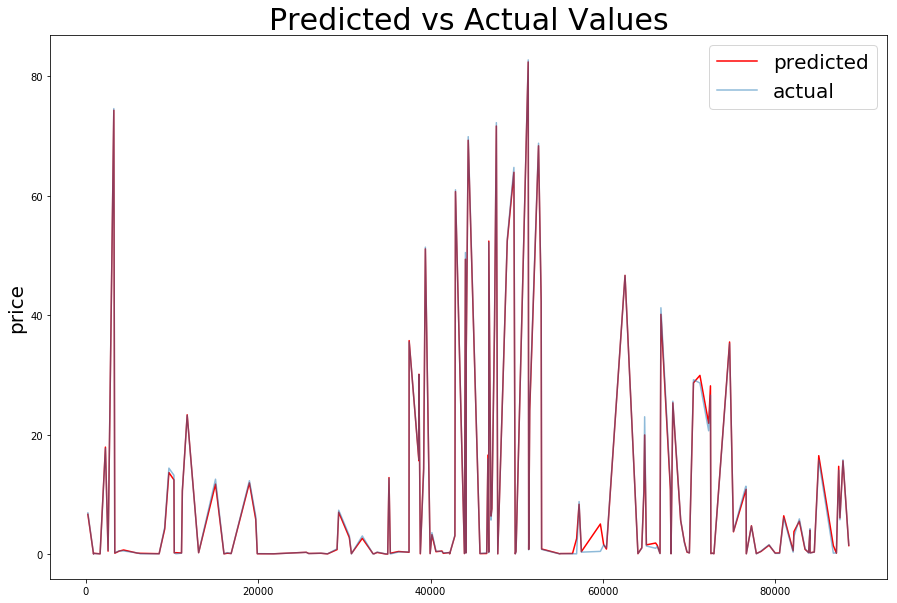

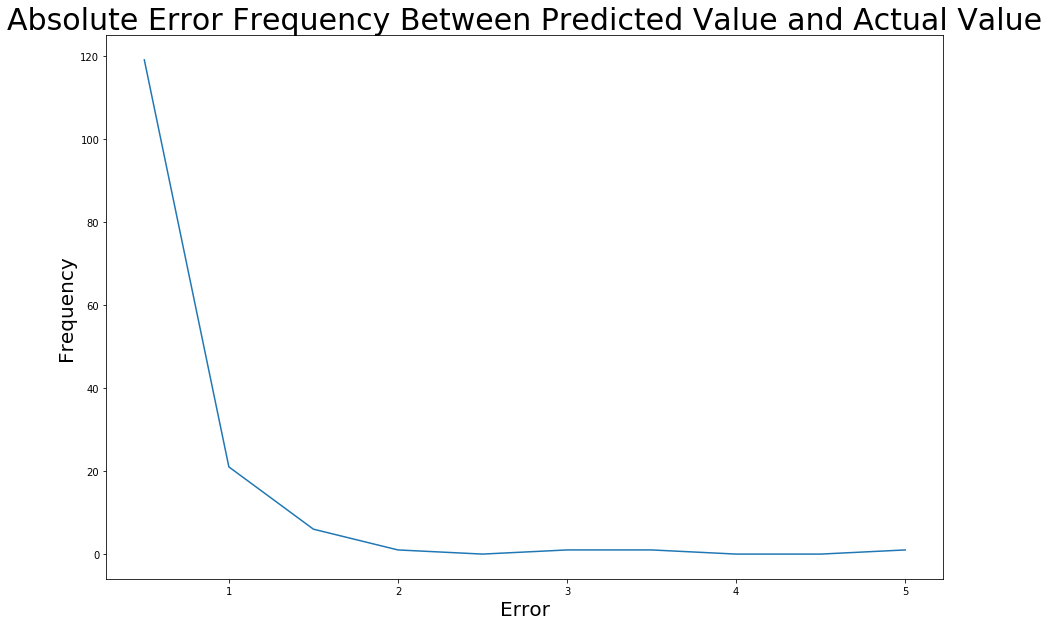

Mean absolute error (MAE):      0.319347
Mean squared error (MSE):       0.470434
R square (R^2):                 0.998555


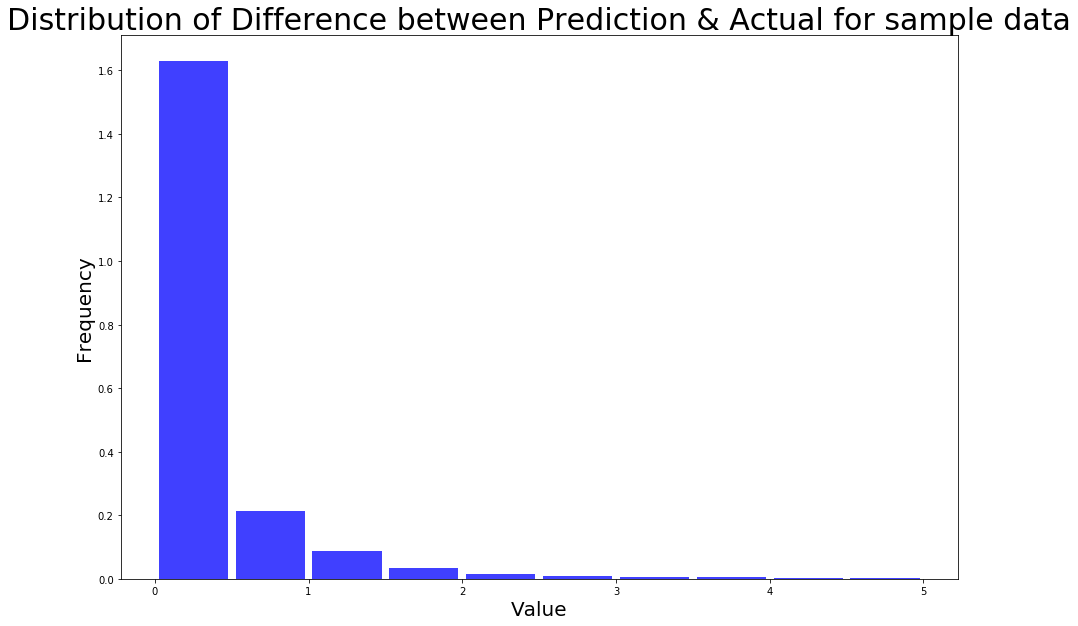

In [98]:
model_pred(p_df_ITM, model_ITM, 'impl_volatility')

,predict,actual
0,0.310441,0.13
1,0.087745,0.13
2,0.111022,0.06
3,0.090105,0.04
4,0.068919,0.03
5,0.069341,0.03
6,0.078434,0.03
7,0.094860,0.02
8,0.107993,0.06
9,0.111360,0.05


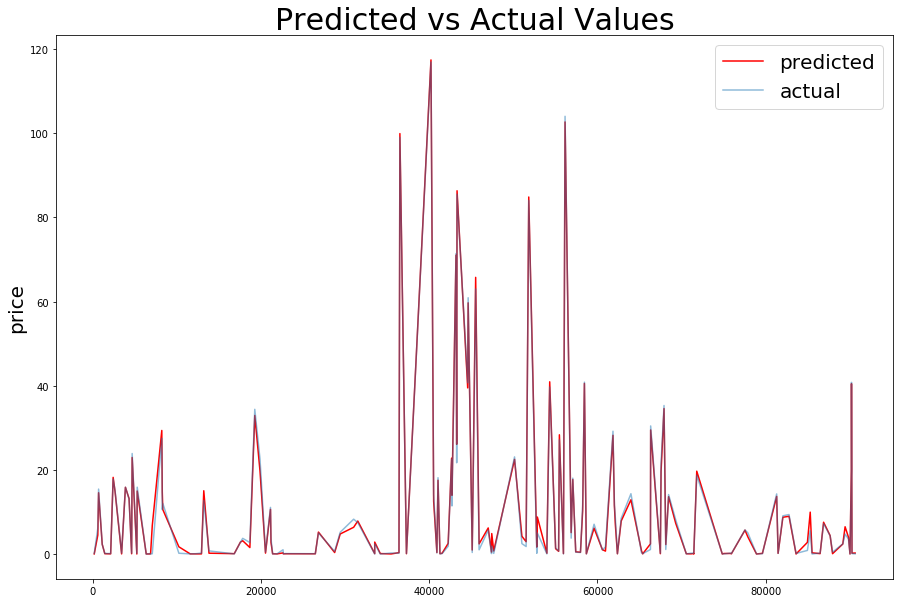

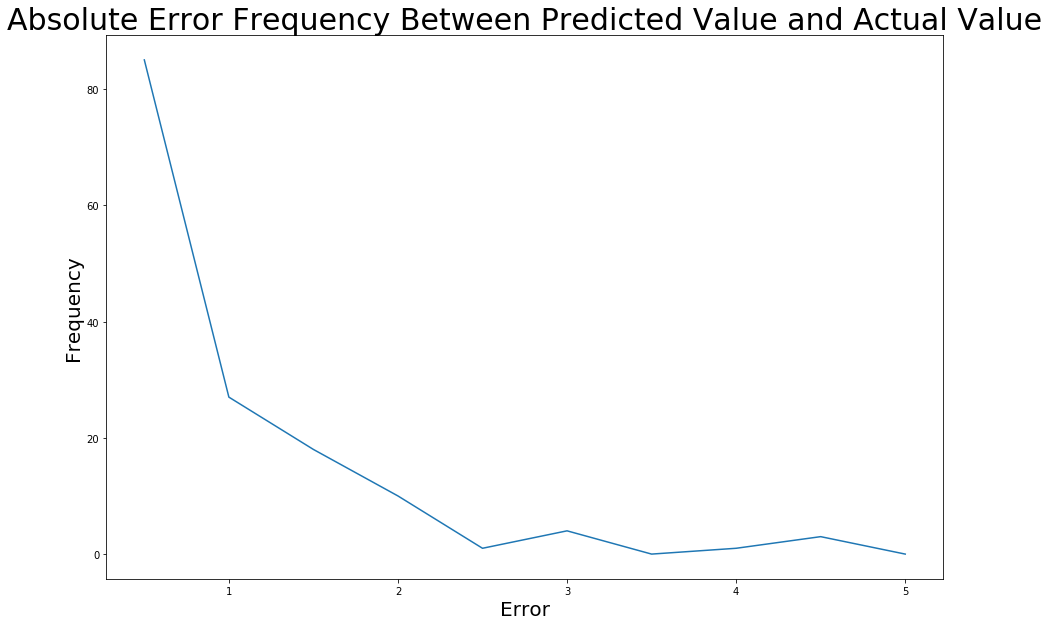

Mean absolute error (MAE):      0.750095
Mean squared error (MSE):       1.901307
R square (R^2):                 0.994162


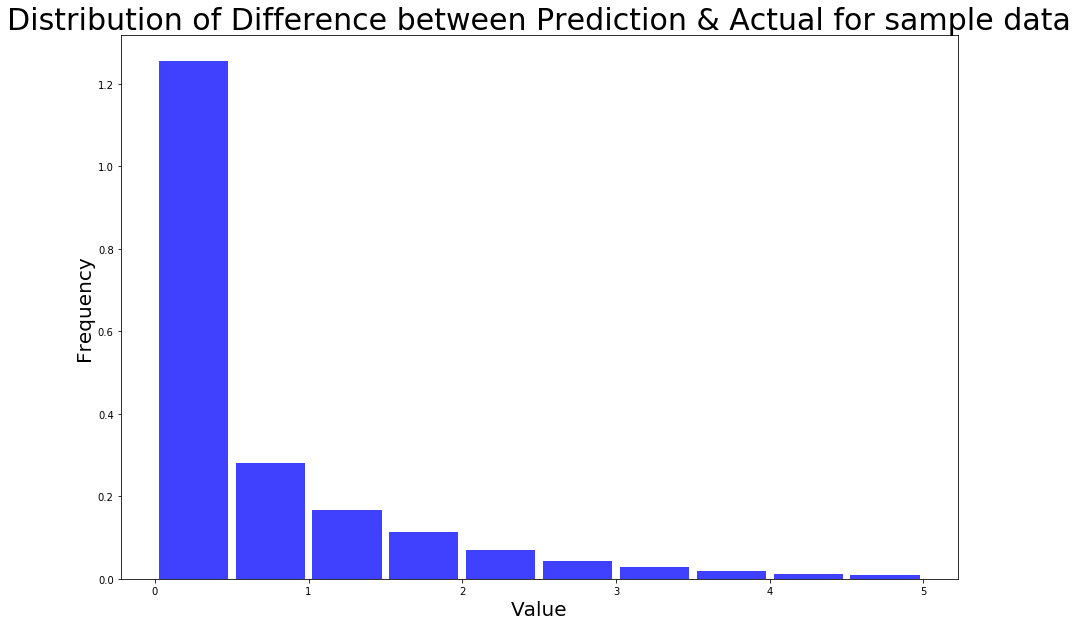

In [99]:
model_pred(p_df_ITM, model_ITM, 'realized_vol')

## Predict at-the-money option data

,predict,actual
0,1.888275,1.70
1,1.552722,1.31
2,1.193679,0.95
3,0.855299,0.66
4,0.705256,0.44
5,0.483580,0.28
6,0.315382,0.17
7,0.190274,0.10
8,0.238596,0.34
9,0.332473,0.48


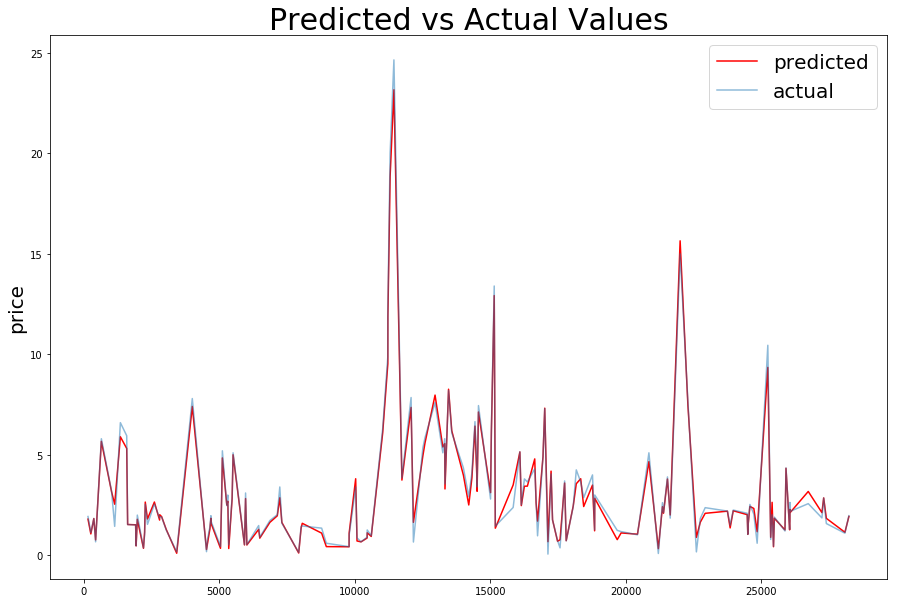

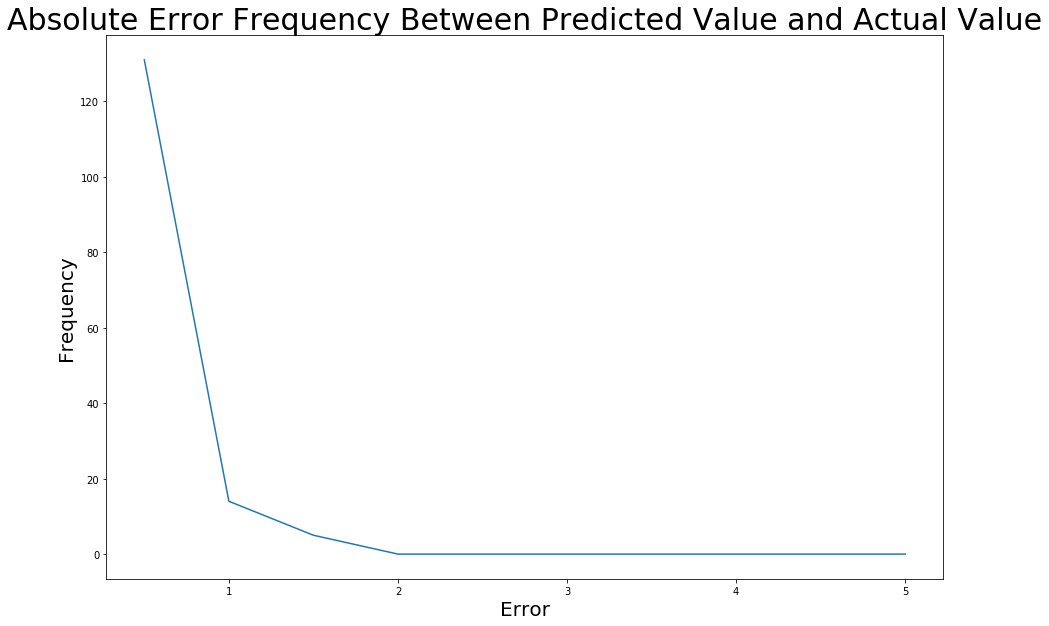

Mean absolute error (MAE):      0.231523
Mean squared error (MSE):       0.168745
R square (R^2):                 0.985128


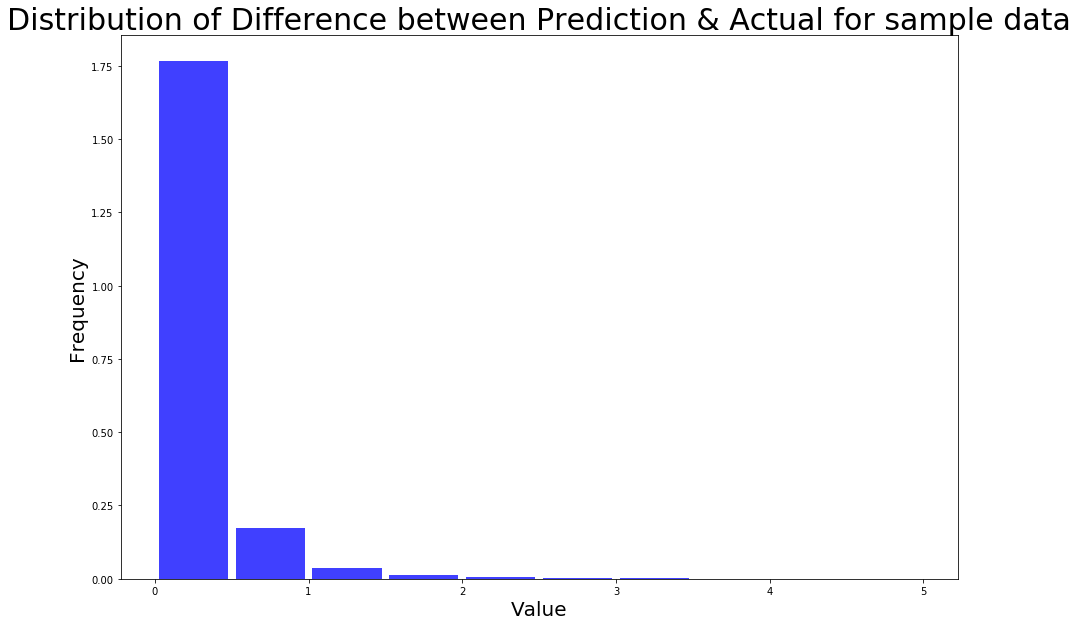

In [100]:
model_pred(p_df_ATM, model_ATM, 'impl_volatility')

,predict,actual
0,1.767633,1.70
1,1.406122,1.31
2,1.032573,0.95
3,0.709086,0.66
4,0.464839,0.44
5,0.309790,0.28
6,0.196216,0.17
7,0.118973,0.10
8,0.141966,0.34
9,0.244274,0.48


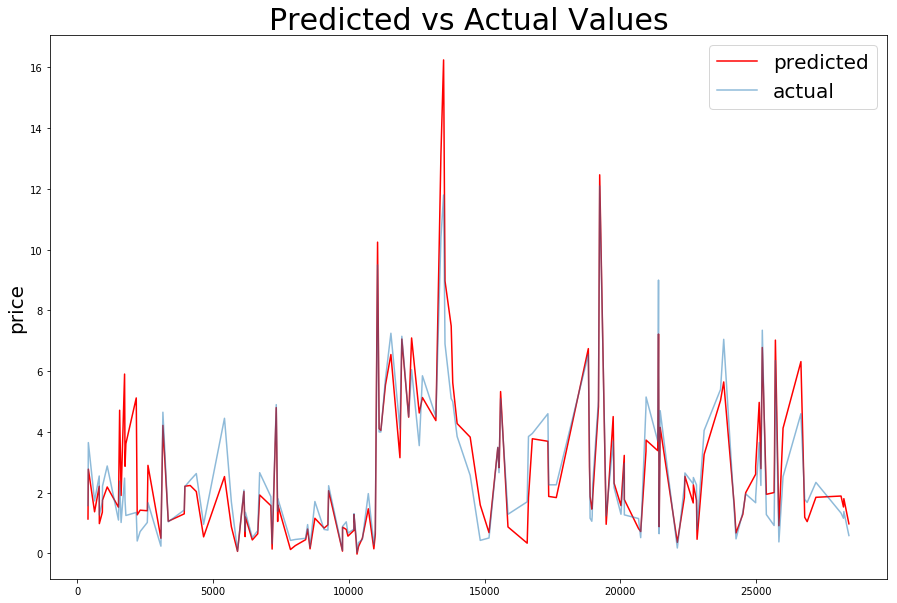

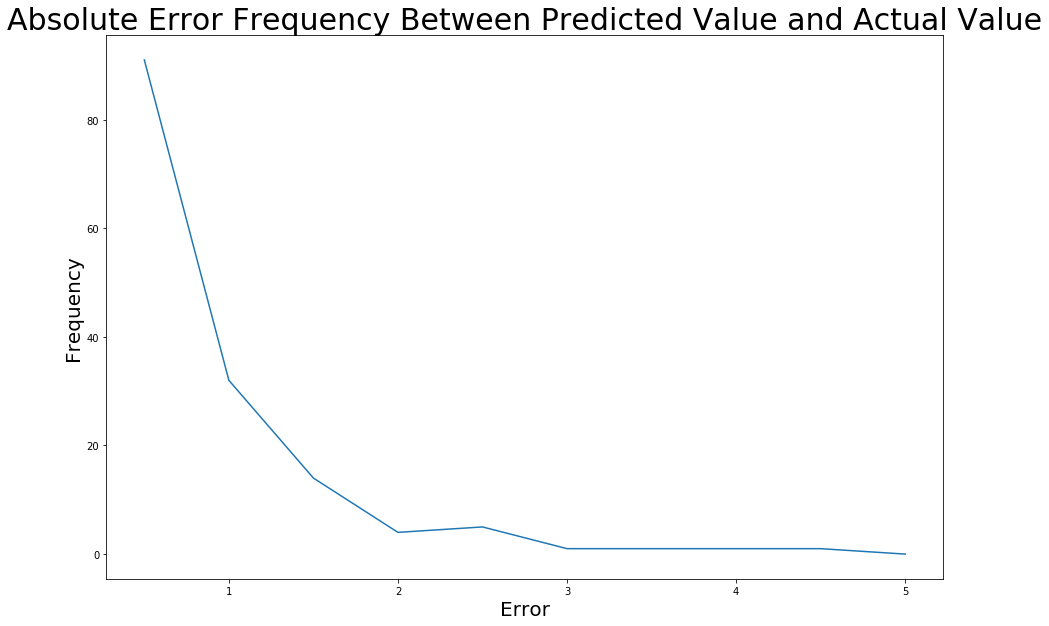

Mean absolute error (MAE):      0.681505
Mean squared error (MSE):       1.104231
R square (R^2):                 0.902679


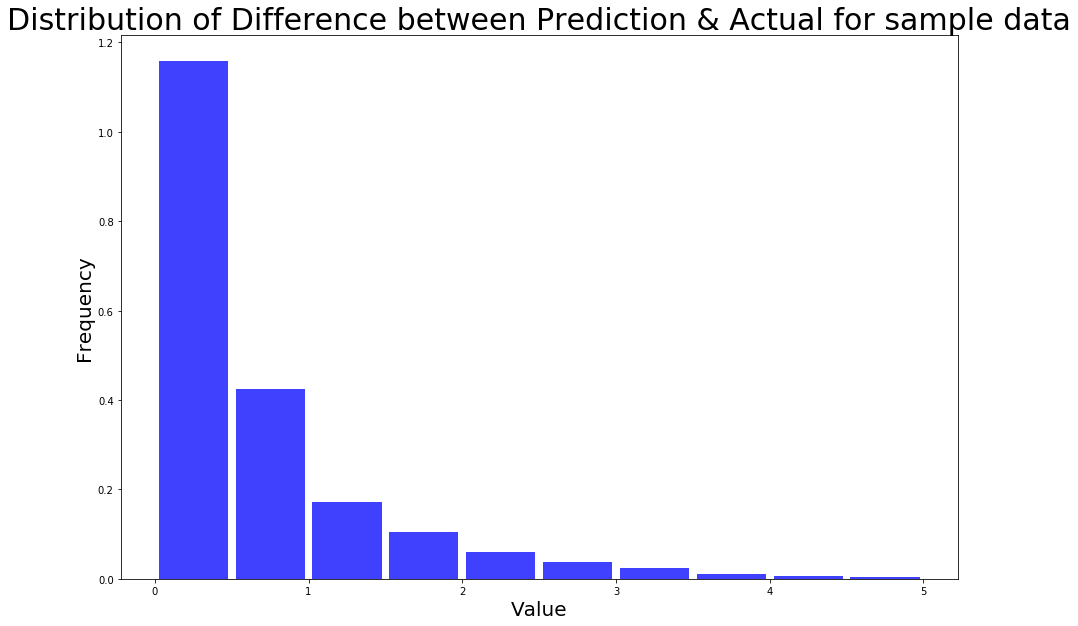

In [101]:
model_pred(p_df_ATM, model_ATM, 'realized_vol')

## Predict out-the-money option data

,predict,actual
0,0.335971,0.14
1,0.301158,0.13
2,0.308651,0.12
3,0.164126,0.06
4,0.069308,0.02
5,0.097158,0.04
6,0.107852,0.05
7,0.109774,0.06
8,0.121415,0.08
9,0.142370,0.10


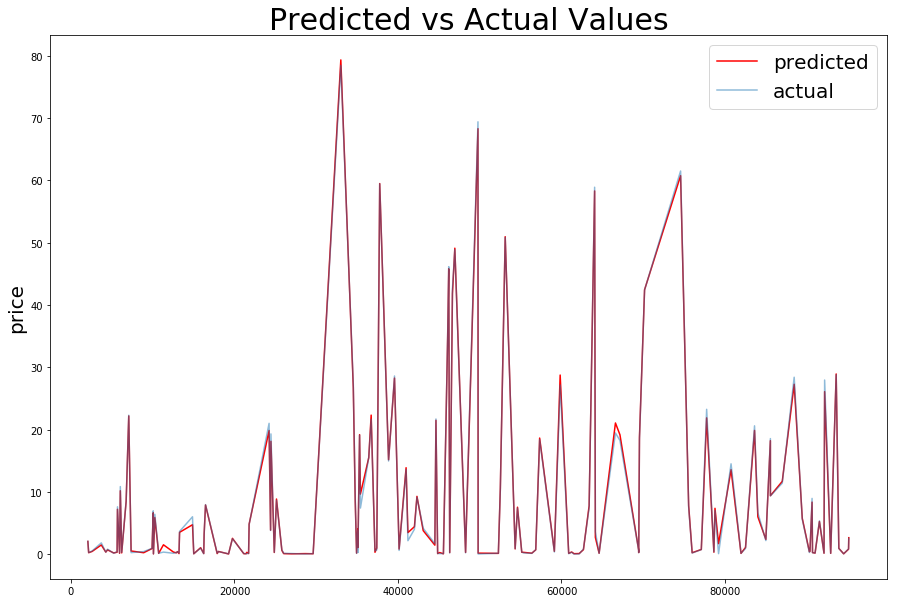

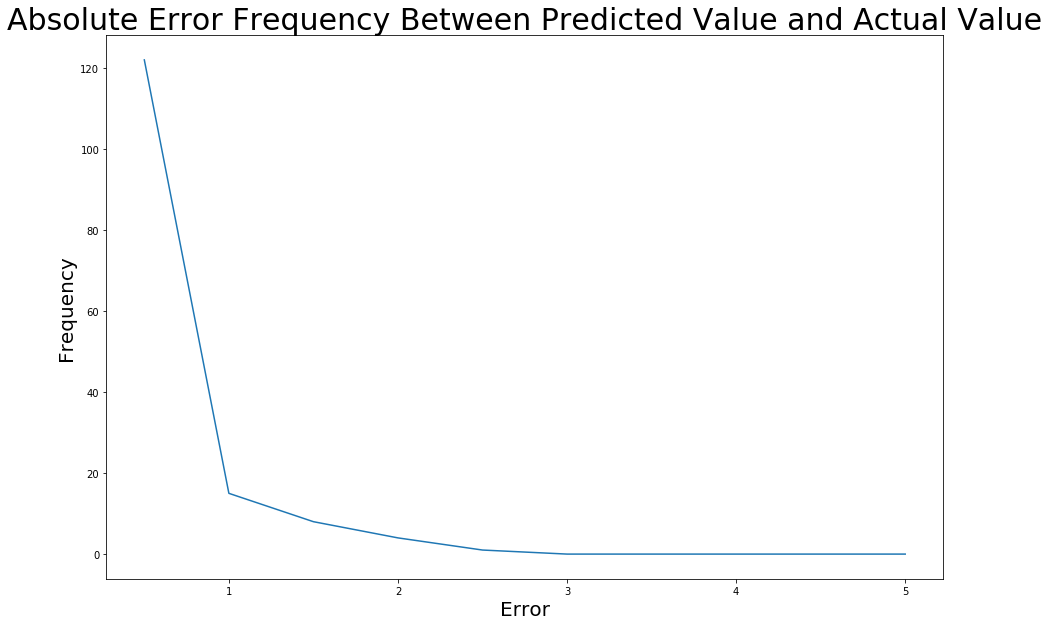

Mean absolute error (MAE):      0.310776
Mean squared error (MSE):       0.435280
R square (R^2):                 0.997535


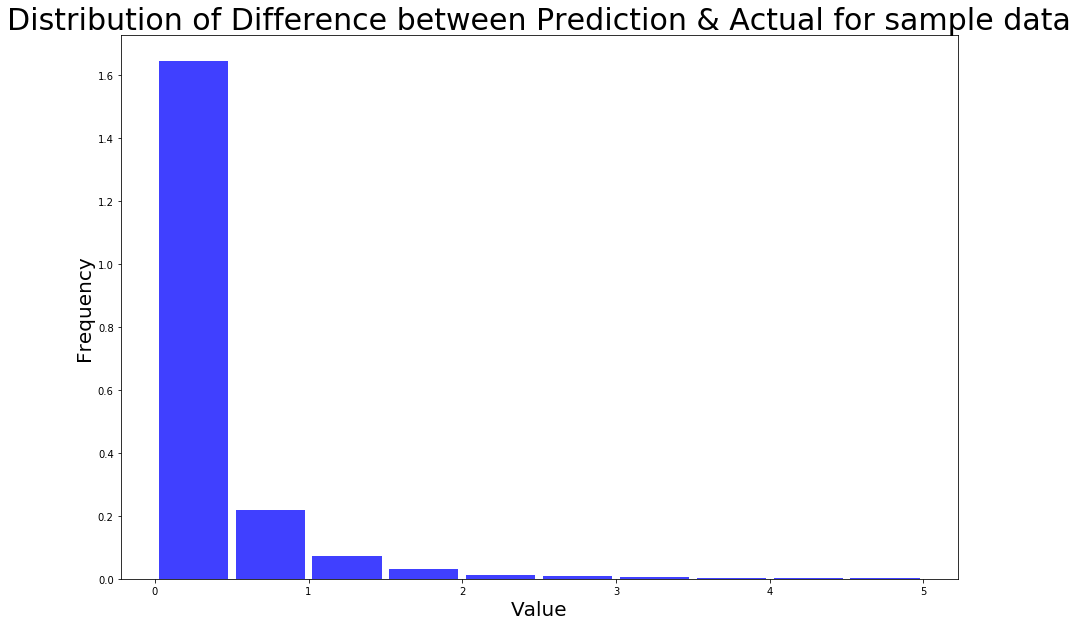

In [102]:
model_pred(p_df_OTM, model_OTM, 'impl_volatility')

,predict,actual
0,0.073097,0.14
1,0.083003,0.13
2,0.105932,0.12
3,0.059640,0.06
4,0.003689,0.02
5,0.016209,0.04
6,0.019742,0.05
7,0.037664,0.06
8,0.047258,0.08
9,0.046749,0.10


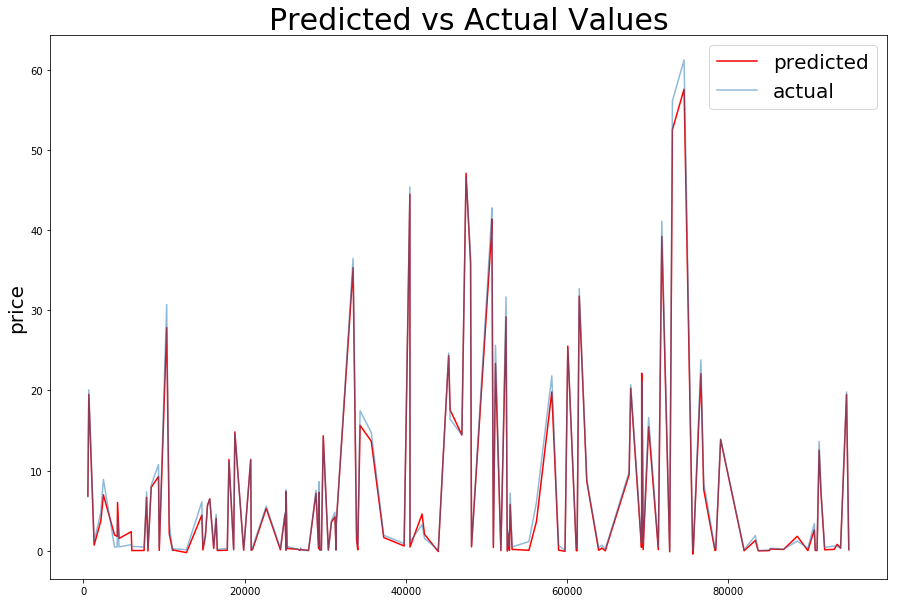

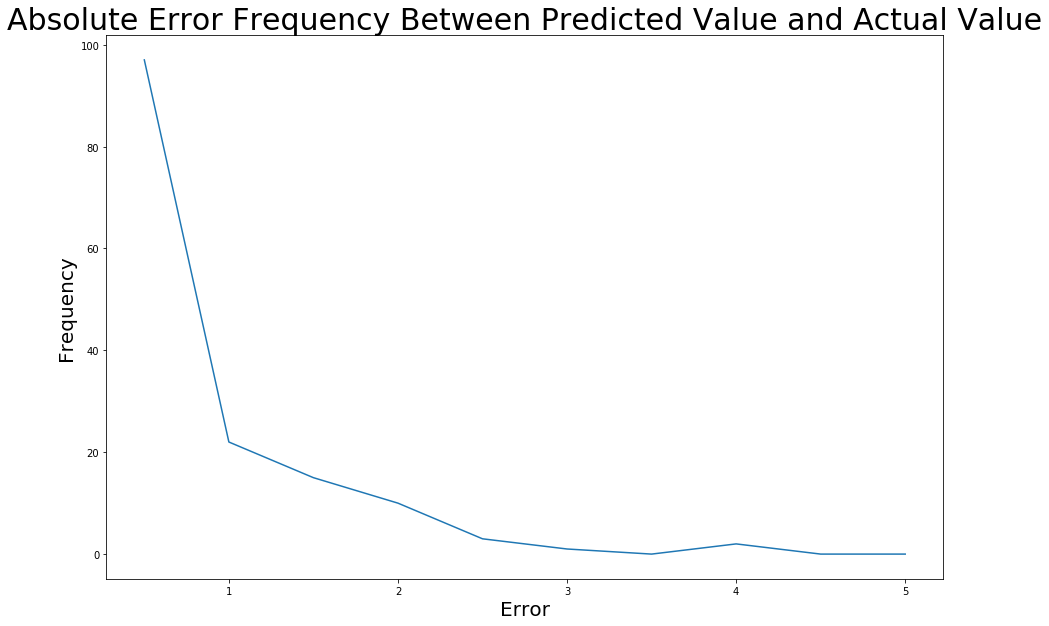

Mean absolute error (MAE):      0.615241
Mean squared error (MSE):       0.975295
R square (R^2):                 0.994477


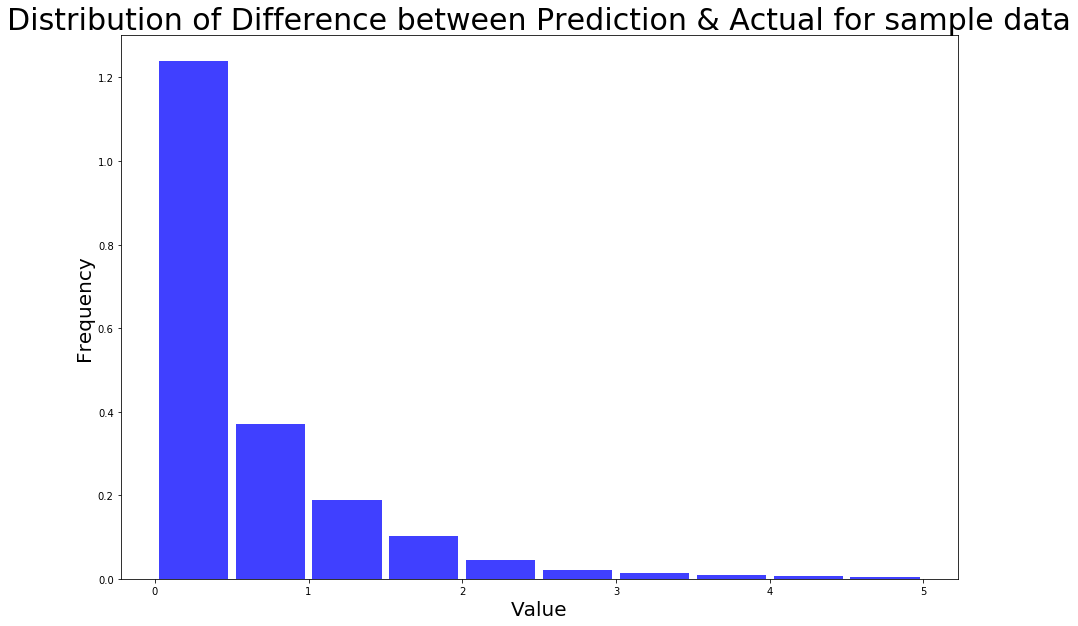

In [103]:
model_pred(p_df_OTM, model_OTM, 'realized_vol')

## Predict whole option data

,predict,actual
0,1.190451,0.13
1,1.636795,0.13
2,1.866033,1.70
3,1.446850,1.31
4,1.122850,0.95
5,0.876944,0.66
6,0.537932,0.44
7,0.357607,0.28
8,0.256684,0.17
9,0.183156,0.10


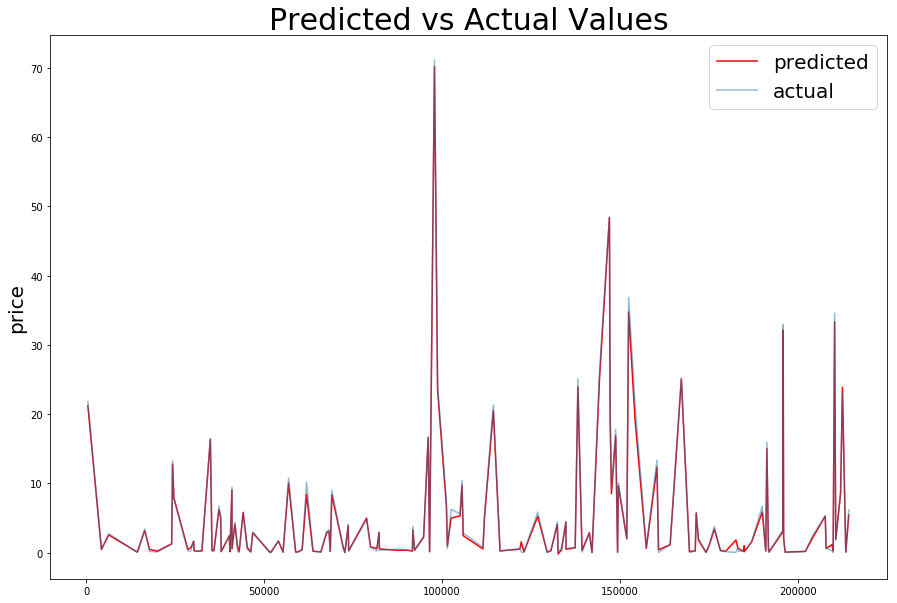

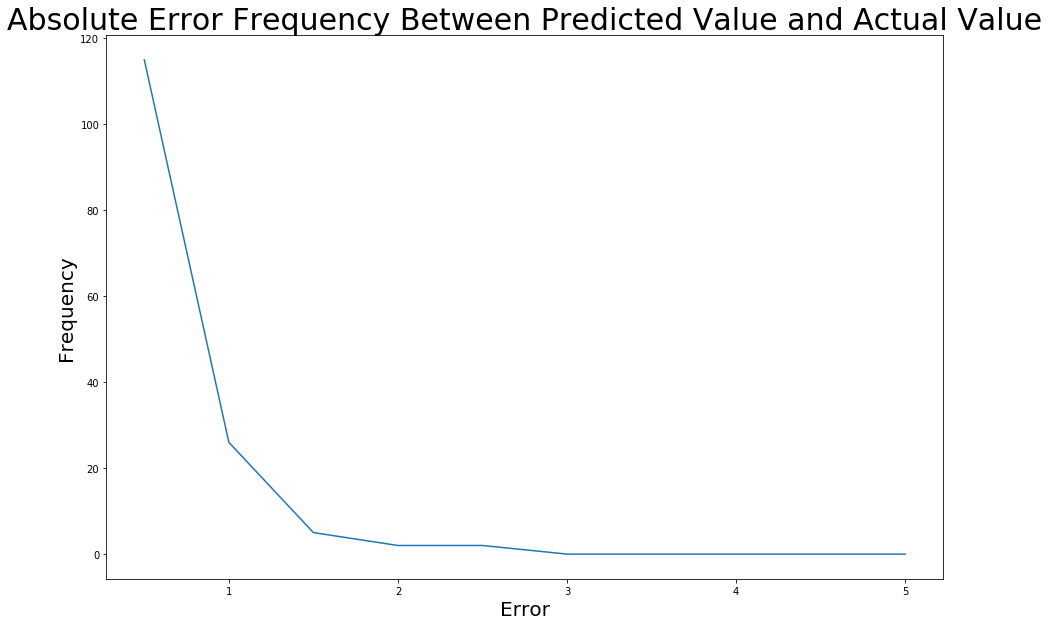

Mean absolute error (MAE):      0.314238
Mean squared error (MSE):       0.402329
R square (R^2):                 0.998180


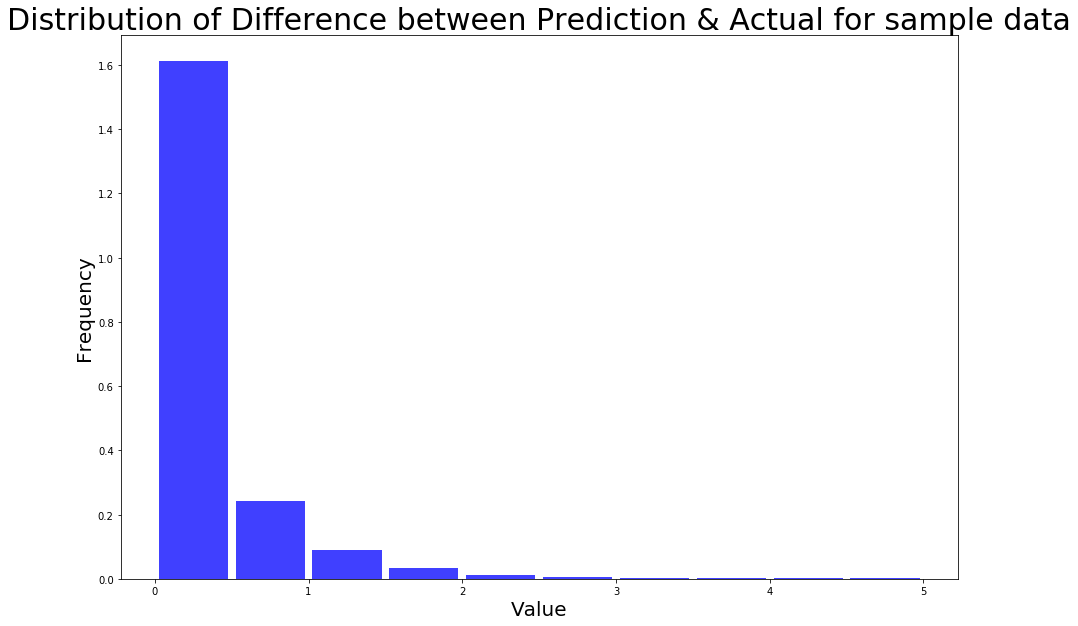

In [104]:
model_pred(p_df, model, 'impl_volatility')

,predict,actual
0,-0.372463,0.13
1,-0.312532,0.13
2,1.742596,1.70
3,1.266136,1.31
4,1.024714,0.95
5,0.720994,0.66
6,0.489822,0.44
7,0.339777,0.28
8,0.247436,0.17
9,0.143660,0.10


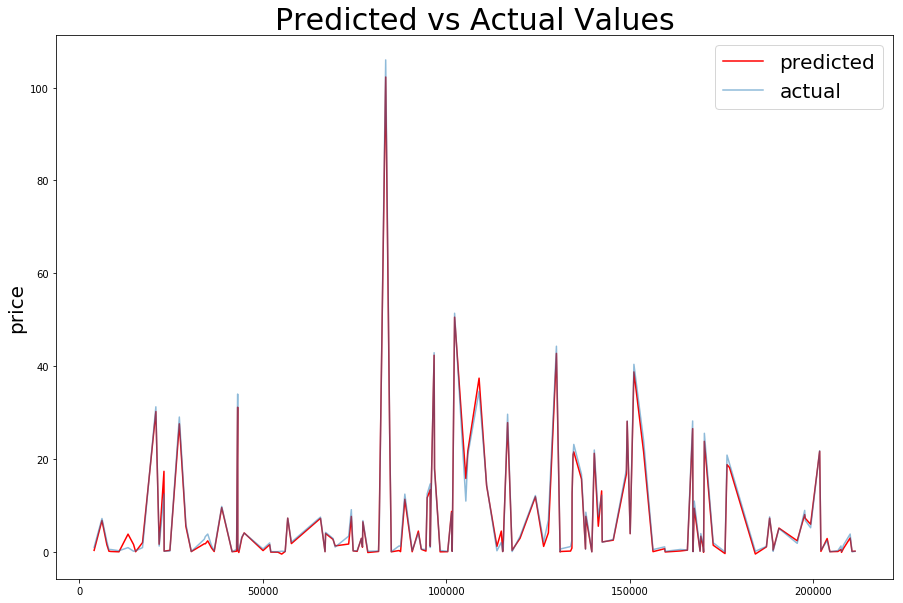

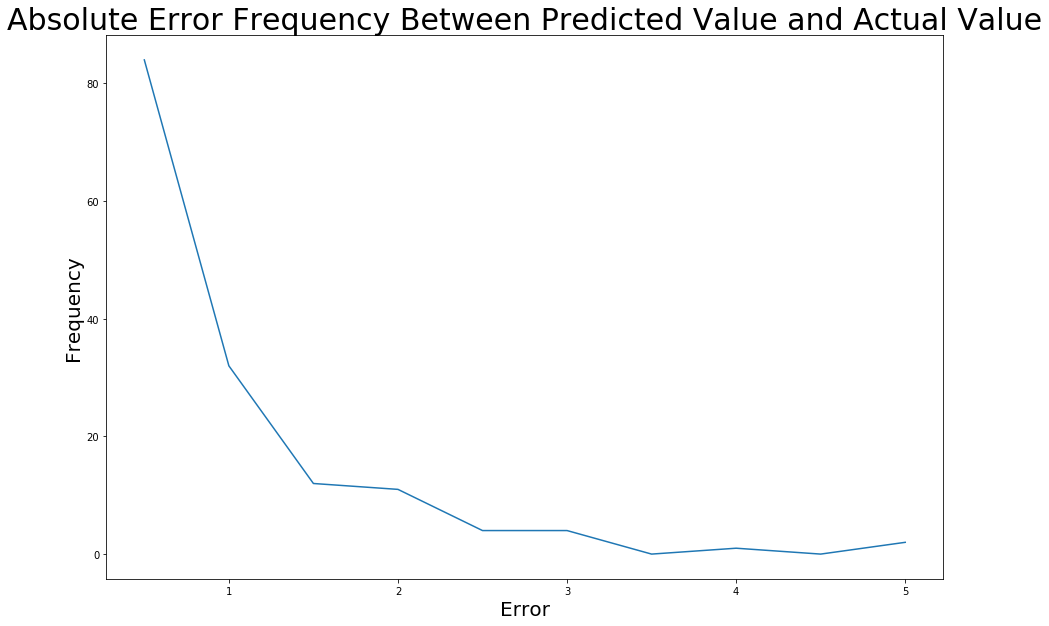

Mean absolute error (MAE):      0.648055
Mean squared error (MSE):       1.091231
R square (R^2):                 0.995063


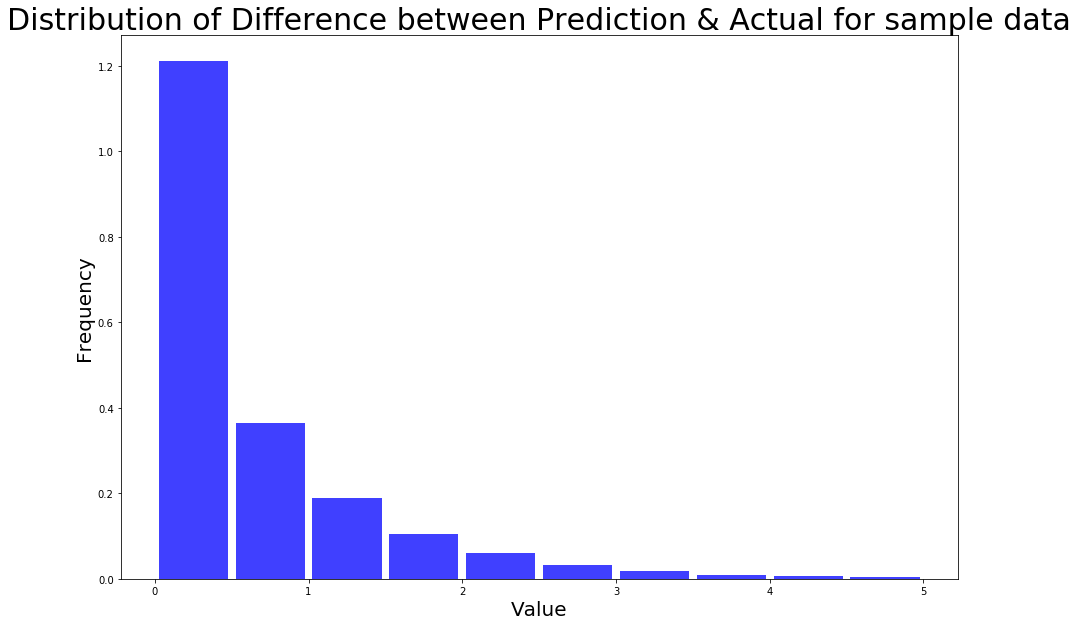

In [105]:
model_pred(p_df, model, 'realized_vol')

In [78]:
def load_AAPL():
    AAPL = pd.read_csv('Options2016AAPL_withReaVo.csv')
    AAPL = AAPL.dropna()
    AAPL.rename(columns = {'Strike Price':'strike_price', 'Lowest  Closing Ask Across All Exchanges':'best_offer', 
                           'Underlying Price':'underlying_price', 'C=Call, P=Put_C':'cp_flag_C', 'C=Call, P=Put_P':'cp_flag_P',
                           'volatility':'realized_vol'}, inplace = True);
    AAPL['intrinsic'] = AAPL.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], 
                                                         row['cp_flag_P']), axis = 1)
    AAPL['moneyness'] = AAPL.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    
    ITM_df = AAPL[AAPL['moneyness'] <= 0.97]
    ATM_df = AAPL[AAPL['moneyness'].between(0.97, 1.03, inclusive = False)]
    OTM_df = AAPL[AAPL['moneyness'] >= 1.03]
    
    return AAPL, ITM_df, ATM_df, OTM_df

In [79]:
AAPL, AAPL_ITM, AAPL_ATM, AAPL_OTM = load_AAPL()

,predict,actual
0,0.137529,0.18
1,0.086951,0.10
2,0.094020,0.06
3,0.085845,0.04
4,0.121116,0.03
5,0.143496,0.03
6,0.164846,0.02
7,0.176923,0.02
8,0.179731,0.02
9,0.178005,0.02


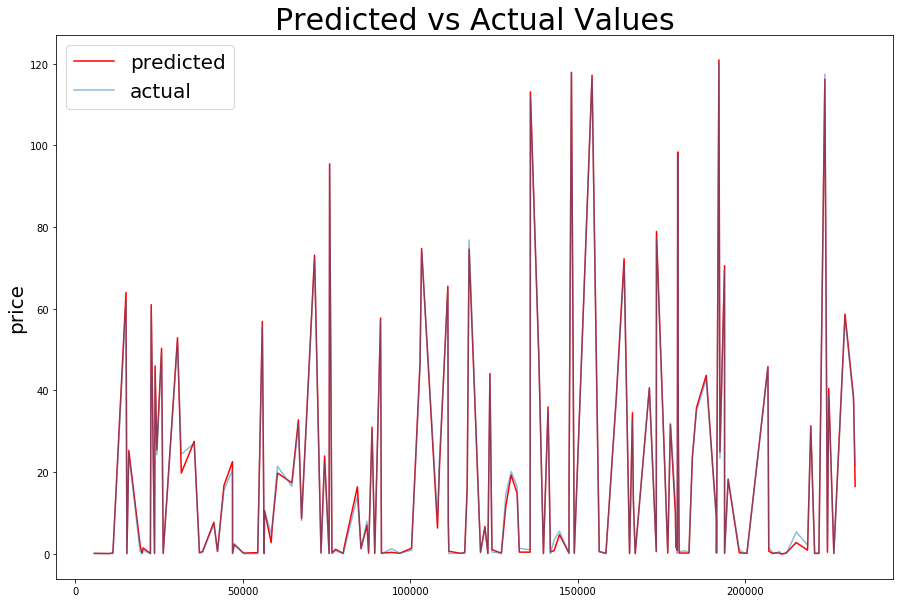

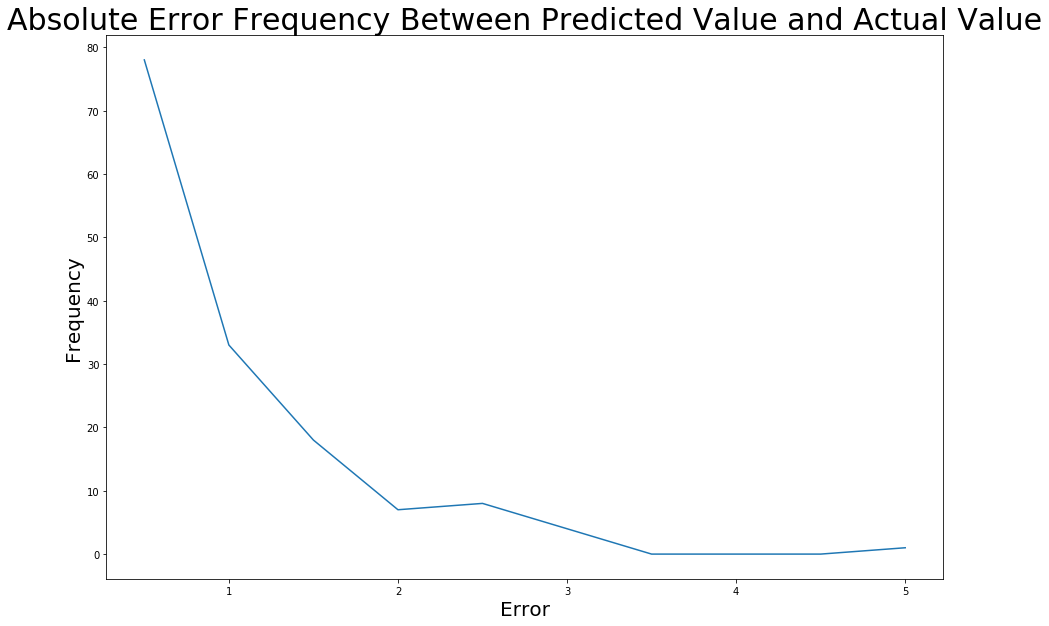

Mean absolute error (MAE):      0.702188
Mean squared error (MSE):       1.247571
R square (R^2):                 0.998226


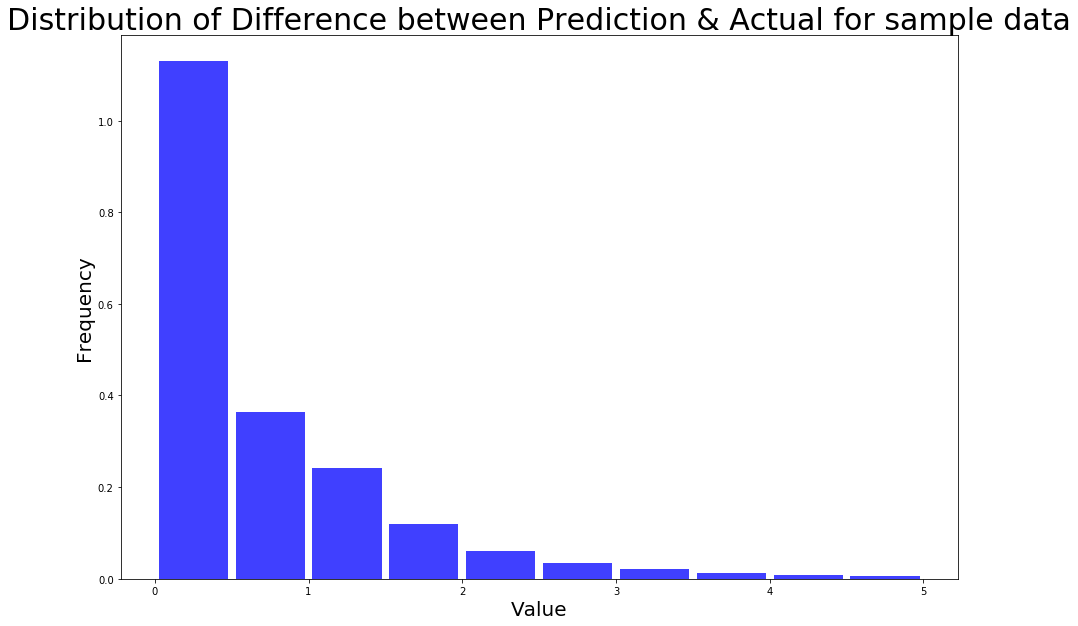

In [106]:
model_pred(AAPL_ITM, model_ITM, 'realized_vol')

,predict,actual
0,2.720099,2.79
1,1.948439,2.06
2,1.335119,1.43
3,0.832184,0.93
4,0.515154,0.56
5,0.290886,0.32
6,0.303480,0.61
7,0.540654,0.88
8,0.899511,1.25
9,1.546322,1.76


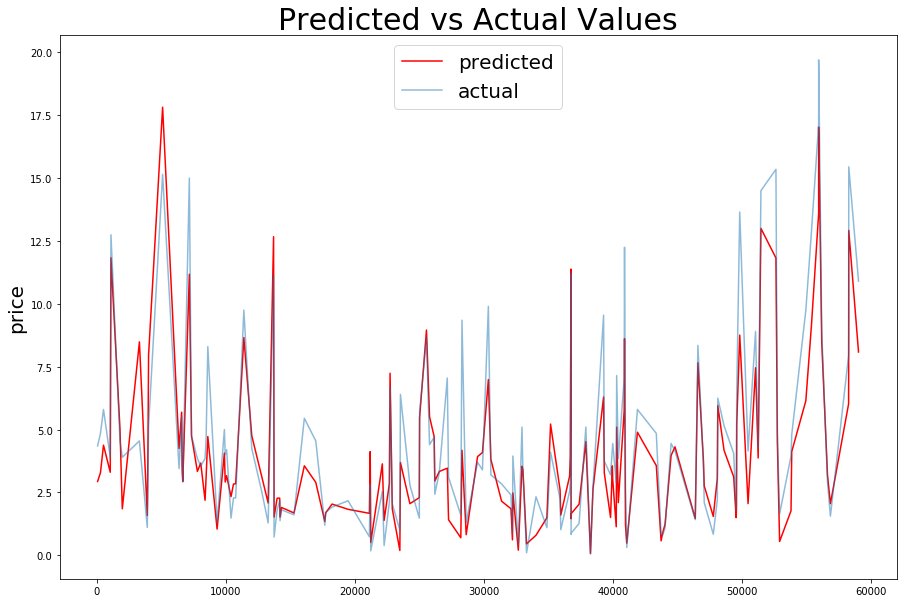

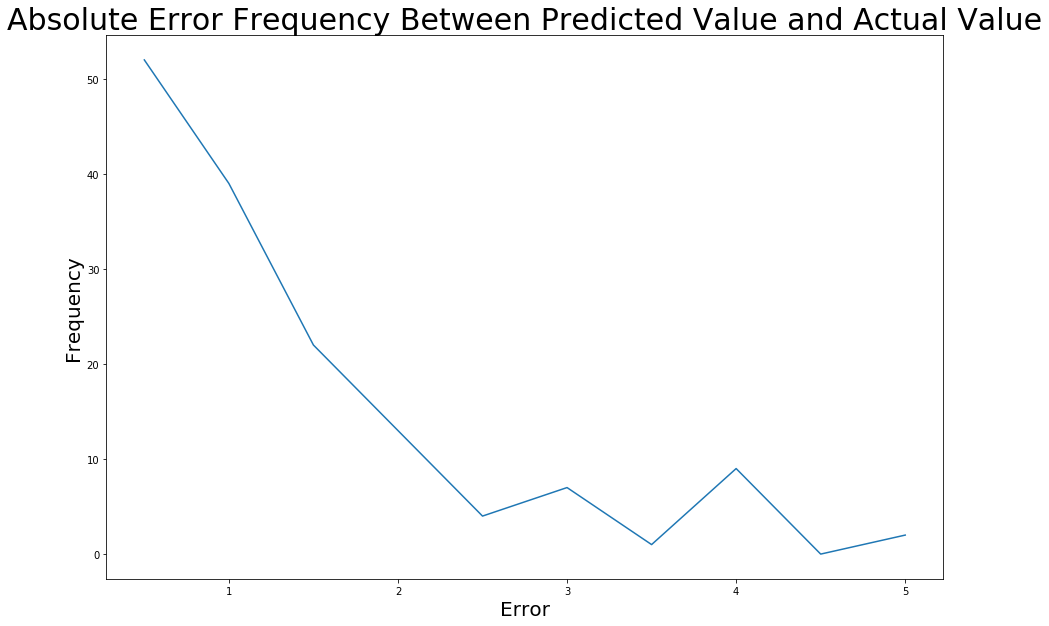

Mean absolute error (MAE):      1.104792
Mean squared error (MSE):       2.607637
R square (R^2):                 0.851337


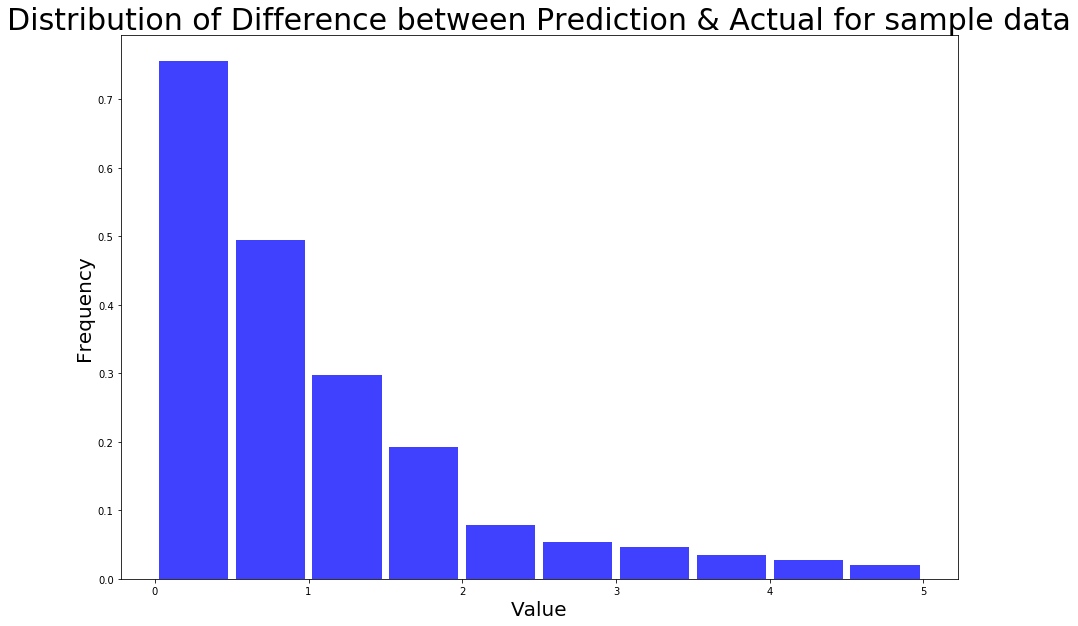

In [107]:
model_pred(AAPL_ATM, model_ATM, 'realized_vol')

,predict,actual
0,5.758888,5.45
1,4.810465,4.50
2,3.810747,3.65
3,6.711909,6.45
4,0.054028,0.23
5,0.077858,0.31
6,0.112278,0.43
7,-0.340585,0.02
8,-0.380609,0.02
9,-0.318812,0.02


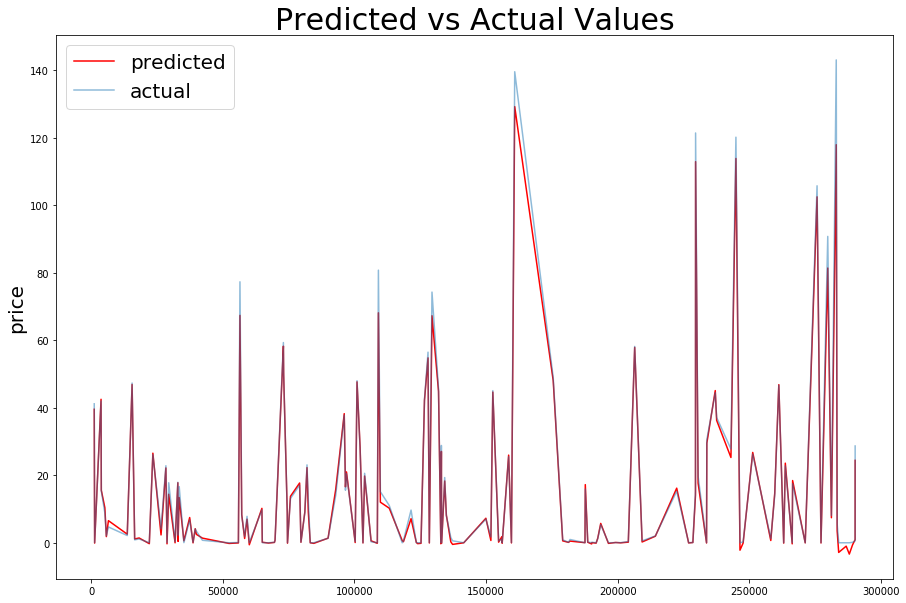

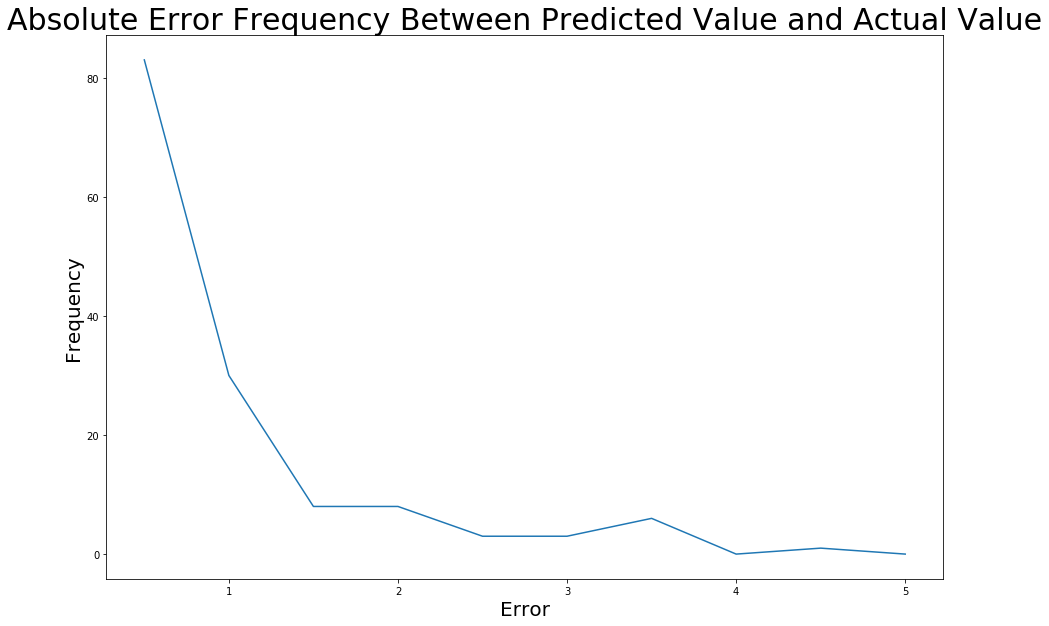

Mean absolute error (MAE):      1.118419
Mean squared error (MSE):       7.465037
R square (R^2):                 0.988441


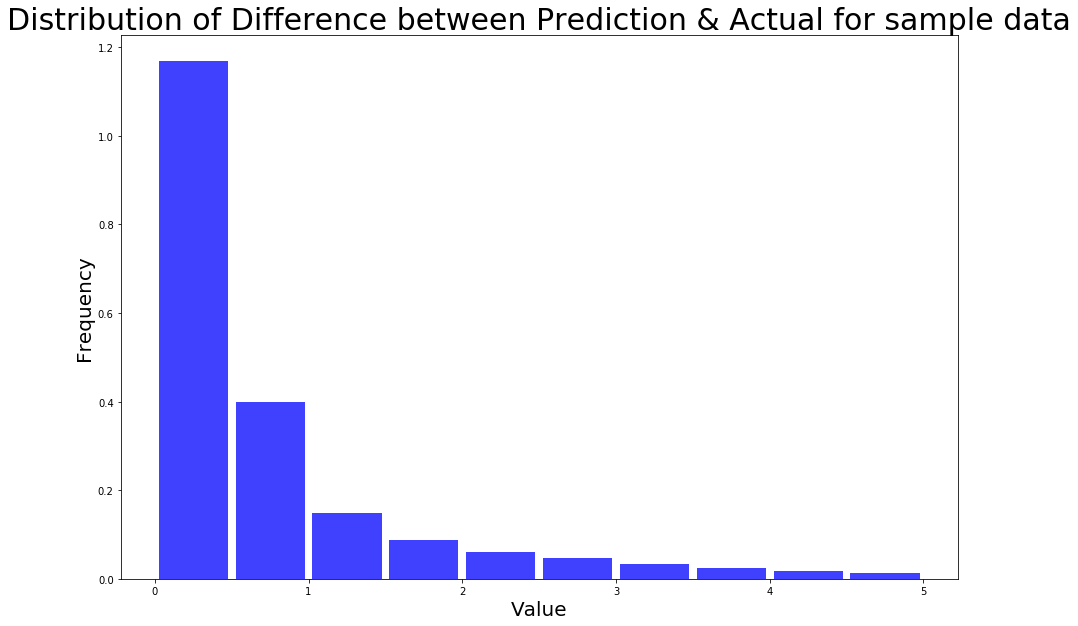

In [108]:
model_pred(AAPL_OTM, model_OTM, 'realized_vol')

,predict,actual
0,5.444057,5.45
1,4.514446,4.50
2,3.587805,3.65
3,2.710947,2.79
4,1.875197,2.06
5,1.411408,1.43
6,0.804390,0.93
7,0.498311,0.56
8,0.292319,0.32
9,0.168537,0.18


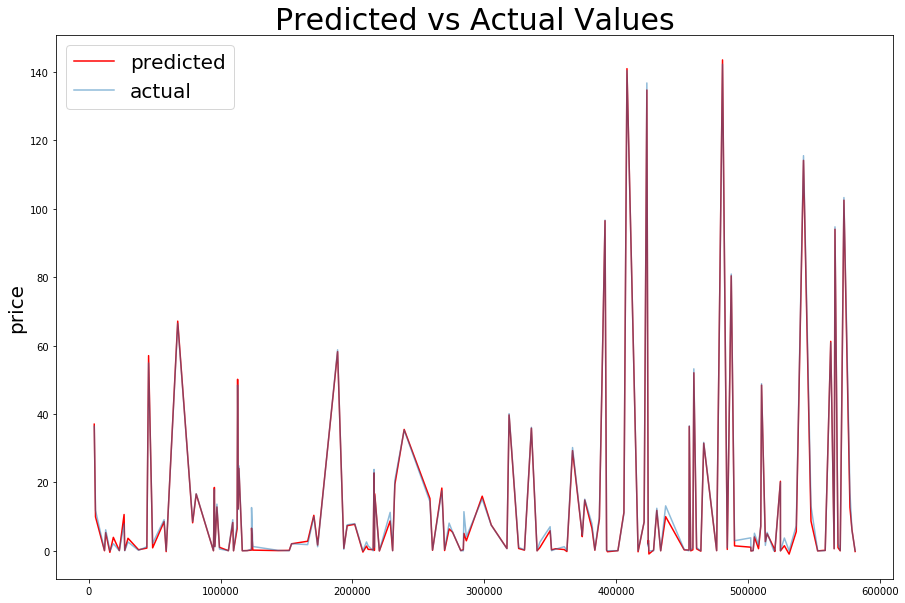

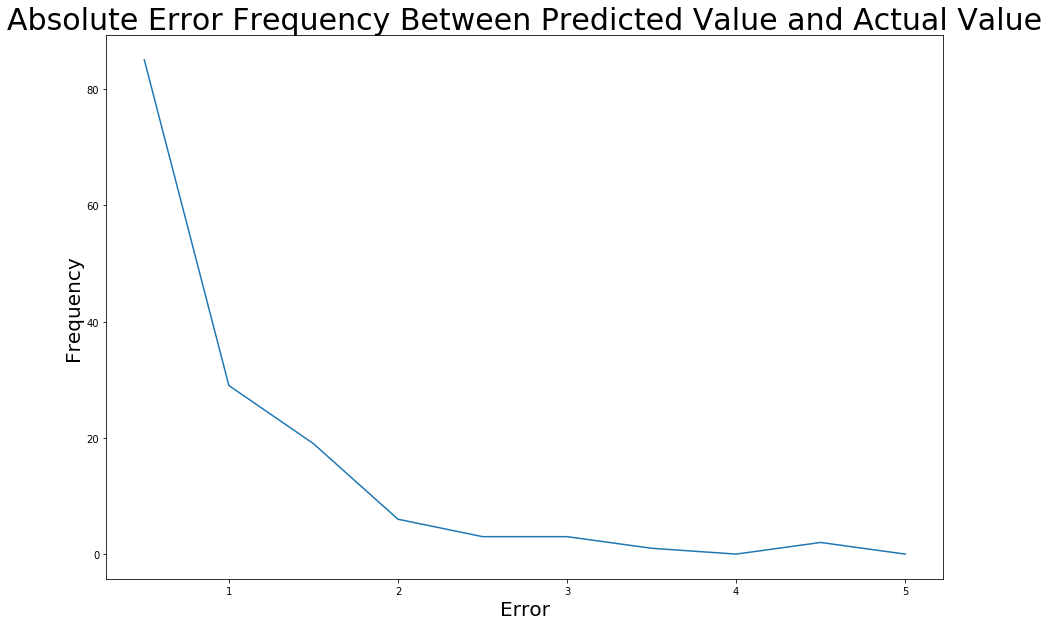

Mean absolute error (MAE):      0.716537
Mean squared error (MSE):       1.338533
R square (R^2):                 0.997830


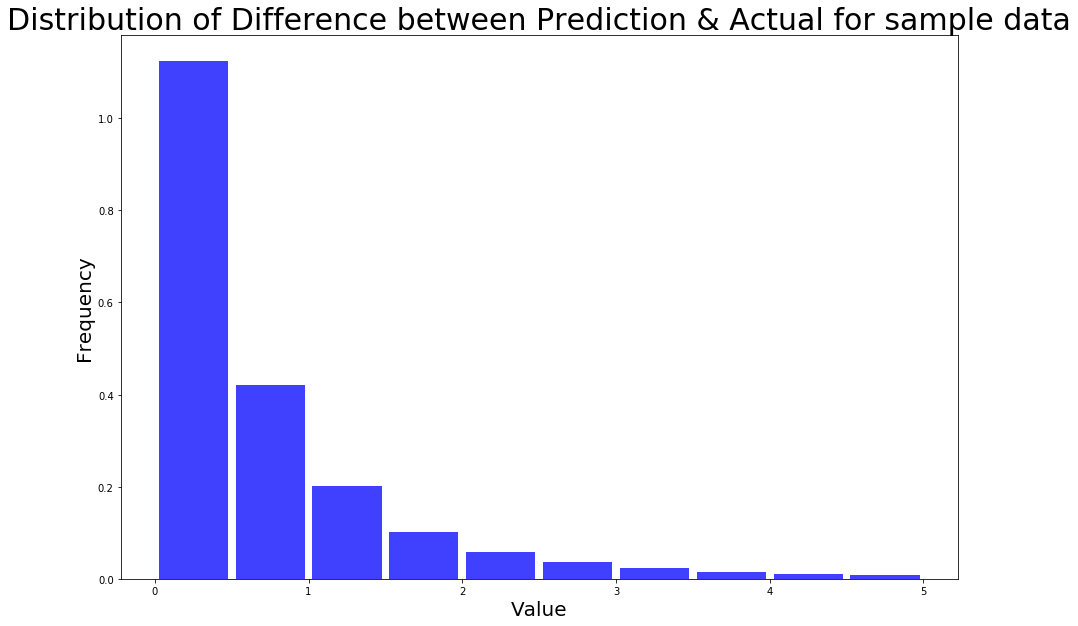

In [109]:
model_pred(AAPL, model, 'realized_vol')

## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>